Libraries

In [ ]:
# !pip install torch torchvision torchaudio tqdm matplotlib torchmetrics pytorch_fid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 36.5 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import save_image, make_grid
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.utils import save_image
from pytorch_fid import fid_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Loading CIFAR10

In [ ]:
# Data loaders and normalization to [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_ds = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_ds  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

VAE Training

In [ ]:
# Define ConvVAE
class ConvVAE(nn.Module):
    def __init__(self, z_dim=64):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),   # 32 -> 16
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1), # 16 -> 8
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1),# 8 -> 4
            nn.BatchNorm2d(256),
            nn.ReLU(True),
        )
        self.fc_mu     = nn.Linear(256 * 4 * 4, z_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, z_dim)

        self.fc_dec = nn.Linear(z_dim, 256 * 4 * 4)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 4 -> 8
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 8 -> 16
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),     # 16 -> 32
            nn.Tanh()
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        mu     = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, 256, 4, 4)
        x_hat = self.dec(h)
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

# Loss function
def vae_loss(x_hat, x, mu, logvar):
    # reconstruction: sum over pixels
    recon_loss = nn.MSELoss(reduction='sum')(x_hat, x)
    # KL divergence
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # total loss is a tensor
    return recon_loss + kl, recon_loss, kl

# Instantiate model and optimizer
z_dim = 64
vae = ConvVAE(z_dim=z_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training settings
num_epochs = 50
kl_anneal_epochs = 10

os.makedirs("vae_checkpoints", exist_ok=True)

for epoch in range(1, num_epochs+1):
    vae.train()
    running_loss = 0.0
    running_recon = 0.0
    running_kl = 0.0

    for x, _ in tqdm(train_loader, desc=f"VAE Epoch {epoch}/{num_epochs}"):
        x = x.to(device)
        x_hat, mu, logvar = vae(x)
        loss, recon_loss, kl_loss = vae_loss(x_hat, x, mu, logvar)

        # KL annealing for weight
        kl_weight = min(1.0, epoch / kl_anneal_epochs)
        total_loss = recon_loss + kl_weight * kl_loss

        optimizer.zero_grad()
        total_loss.backward()  # must be a tensor
        optimizer.step()

        running_loss += total_loss.item()
        running_recon += recon_loss.item()
        running_kl    += kl_loss.item()

    # Logging average for epoch
    num_data = len(train_loader.dataset)
    print(f"Epoch {epoch}: Avg Loss {running_loss/num_data:.6f}, Recon {running_recon/num_data:.6f}, KL {running_kl/num_data:.6f}")

    # Save checkpoint
    torch.save(vae.state_dict(), f"vae_checkpoints/vae_epoch_{epoch}.pth")

    # Save sample from prior
    vae.eval()
    with torch.no_grad():
        z_prior = torch.randn(64, z_dim, device=device)
        samples = vae.decode(z_prior)
        samples = samples.cpu().clamp(-1,1)
        samples = (samples + 1)/2
        save_image(samples, f"vae_checkpoints/samples_epoch_{epoch}.png", nrow=8)

        x0, _ = next(iter(test_loader))
        x0 = x0.to(device)[:8]
        recon0, _, _ = vae(x0)
        combined = torch.cat([(x0.cpu().clamp(-1,1)+1)/2, (recon0.cpu().clamp(-1,1)+1)/2], dim=0)
        save_image(combined, f"vae_checkpoints/recon_epoch_{epoch}.png", nrow=8)


Using device: cuda


100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]
VAE Epoch 1/50: 100%|██████████| 391/391 [00:14<00:00, 27.72it/s]


Epoch 1: Avg Loss 281.423799, Recon 261.671831, KL 197.519683


VAE Epoch 2/50: 100%|██████████| 391/391 [00:12<00:00, 30.68it/s]


Epoch 2: Avg Loss 166.246520, Recon 141.084078, KL 125.812209


VAE Epoch 3/50: 100%|██████████| 391/391 [00:12<00:00, 30.52it/s]

Epoch 3: Avg Loss 159.347108, Recon 125.703607, KL 112.145000



VAE Epoch 4/50: 100%|██████████| 391/391 [00:12<00:00, 31.16it/s]

Epoch 4: Avg Loss 163.739159, Recon 123.617295, KL 100.304659



VAE Epoch 5/50: 100%|██████████| 391/391 [00:12<00:00, 30.69it/s]

Epoch 5: Avg Loss 168.589428, Recon 123.356484, KL 90.465887



VAE Epoch 6/50: 100%|██████████| 391/391 [00:12<00:00, 30.82it/s]

Epoch 6: Avg Loss 174.535092, Recon 124.869248, KL 82.776402



VAE Epoch 7/50: 100%|██████████| 391/391 [00:12<00:00, 30.72it/s]

Epoch 7: Avg Loss 179.717563, Recon 126.263711, KL 76.362647



VAE Epoch 8/50: 100%|██████████| 391/391 [00:12<00:00, 30.90it/s]

Epoch 8: Avg Loss 184.803929, Recon 128.017343, KL 70.983231



VAE Epoch 9/50: 100%|██████████| 391/391 [00:12<00:00, 30.51it/s]

Epoch 9: Avg Loss 189.799766, Recon 130.028045, KL 66.413026



VAE Epoch 10/50: 100%|██████████| 391/391 [00:13<00:00, 28.29it/s]


Epoch 10: Avg Loss 194.446177, Recon 131.881204, KL 62.564973


VAE Epoch 11/50: 100%|██████████| 391/391 [00:12<00:00, 30.53it/s]


Epoch 11: Avg Loss 193.076860, Recon 131.026854, KL 62.050007


VAE Epoch 12/50: 100%|██████████| 391/391 [00:12<00:00, 30.87it/s]


Epoch 12: Avg Loss 192.351373, Recon 130.666829, KL 61.684544


VAE Epoch 13/50: 100%|██████████| 391/391 [00:12<00:00, 31.12it/s]

Epoch 13: Avg Loss 192.040984, Recon 130.506504, KL 61.534480



VAE Epoch 14/50: 100%|██████████| 391/391 [00:12<00:00, 30.35it/s]

Epoch 14: Avg Loss 190.769632, Recon 129.339326, KL 61.430305



VAE Epoch 15/50: 100%|██████████| 391/391 [00:12<00:00, 30.60it/s]


Epoch 15: Avg Loss 190.077198, Recon 128.845628, KL 61.231569


VAE Epoch 16/50: 100%|██████████| 391/391 [00:12<00:00, 30.59it/s]

Epoch 16: Avg Loss 189.542306, Recon 128.344905, KL 61.197401



VAE Epoch 17/50: 100%|██████████| 391/391 [00:12<00:00, 31.31it/s]


Epoch 17: Avg Loss 189.245153, Recon 128.237301, KL 61.007852


VAE Epoch 18/50: 100%|██████████| 391/391 [00:12<00:00, 31.31it/s]


Epoch 18: Avg Loss 188.893945, Recon 127.937997, KL 60.955948


VAE Epoch 19/50: 100%|██████████| 391/391 [00:13<00:00, 28.95it/s]

Epoch 19: Avg Loss 188.122650, Recon 127.065004, KL 61.057646



VAE Epoch 20/50: 100%|██████████| 391/391 [00:12<00:00, 30.99it/s]

Epoch 20: Avg Loss 187.712853, Recon 126.743776, KL 60.969077



VAE Epoch 21/50: 100%|██████████| 391/391 [00:12<00:00, 30.61it/s]

Epoch 21: Avg Loss 187.293521, Recon 126.388399, KL 60.905122



VAE Epoch 22/50: 100%|██████████| 391/391 [00:12<00:00, 31.00it/s]


Epoch 22: Avg Loss 187.032394, Recon 126.153251, KL 60.879142


VAE Epoch 23/50: 100%|██████████| 391/391 [00:12<00:00, 30.70it/s]


Epoch 23: Avg Loss 186.780116, Recon 125.938698, KL 60.841419


VAE Epoch 24/50: 100%|██████████| 391/391 [00:13<00:00, 29.06it/s]

Epoch 24: Avg Loss 186.485909, Recon 125.623939, KL 60.861969



VAE Epoch 25/50: 100%|██████████| 391/391 [00:12<00:00, 31.07it/s]


Epoch 25: Avg Loss 186.088022, Recon 125.270527, KL 60.817496


VAE Epoch 26/50: 100%|██████████| 391/391 [00:12<00:00, 30.81it/s]

Epoch 26: Avg Loss 185.633746, Recon 124.814973, KL 60.818773



VAE Epoch 27/50: 100%|██████████| 391/391 [00:12<00:00, 31.20it/s]

Epoch 27: Avg Loss 185.497133, Recon 124.700686, KL 60.796447



VAE Epoch 28/50: 100%|██████████| 391/391 [00:12<00:00, 30.91it/s]


Epoch 28: Avg Loss 185.320557, Recon 124.560240, KL 60.760317


VAE Epoch 29/50: 100%|██████████| 391/391 [00:12<00:00, 31.22it/s]

Epoch 29: Avg Loss 184.975712, Recon 124.108167, KL 60.867545



VAE Epoch 30/50: 100%|██████████| 391/391 [00:12<00:00, 30.64it/s]

Epoch 30: Avg Loss 184.842417, Recon 124.080504, KL 60.761913



VAE Epoch 31/50: 100%|██████████| 391/391 [00:12<00:00, 31.08it/s]

Epoch 31: Avg Loss 184.512986, Recon 123.716436, KL 60.796549



VAE Epoch 32/50: 100%|██████████| 391/391 [00:12<00:00, 31.22it/s]


Epoch 32: Avg Loss 184.223632, Recon 123.459856, KL 60.763776


VAE Epoch 33/50: 100%|██████████| 391/391 [00:12<00:00, 30.94it/s]

Epoch 33: Avg Loss 184.025531, Recon 123.249264, KL 60.776267



VAE Epoch 34/50: 100%|██████████| 391/391 [00:12<00:00, 31.03it/s]

Epoch 34: Avg Loss 184.094611, Recon 123.403551, KL 60.691060



VAE Epoch 35/50: 100%|██████████| 391/391 [00:12<00:00, 30.47it/s]


Epoch 35: Avg Loss 183.566005, Recon 122.756016, KL 60.809989


VAE Epoch 36/50: 100%|██████████| 391/391 [00:12<00:00, 31.61it/s]


Epoch 36: Avg Loss 183.425286, Recon 122.615021, KL 60.810266


VAE Epoch 37/50: 100%|██████████| 391/391 [00:12<00:00, 31.21it/s]

Epoch 37: Avg Loss 183.461458, Recon 122.610169, KL 60.851289



VAE Epoch 38/50: 100%|██████████| 391/391 [00:13<00:00, 29.27it/s]


Epoch 38: Avg Loss 183.252545, Recon 122.467139, KL 60.785406


VAE Epoch 39/50: 100%|██████████| 391/391 [00:14<00:00, 26.85it/s]

Epoch 39: Avg Loss 183.151386, Recon 122.348551, KL 60.802835



VAE Epoch 40/50: 100%|██████████| 391/391 [00:12<00:00, 30.58it/s]

Epoch 40: Avg Loss 182.874211, Recon 122.092444, KL 60.781767



VAE Epoch 41/50: 100%|██████████| 391/391 [00:12<00:00, 31.08it/s]

Epoch 41: Avg Loss 182.658067, Recon 121.872734, KL 60.785332



VAE Epoch 42/50: 100%|██████████| 391/391 [00:12<00:00, 30.86it/s]

Epoch 42: Avg Loss 182.470105, Recon 121.696854, KL 60.773251



VAE Epoch 43/50: 100%|██████████| 391/391 [00:12<00:00, 31.40it/s]

Epoch 43: Avg Loss 182.487424, Recon 121.653946, KL 60.833478



VAE Epoch 44/50: 100%|██████████| 391/391 [00:12<00:00, 31.33it/s]

Epoch 44: Avg Loss 182.466318, Recon 121.628373, KL 60.837944



VAE Epoch 45/50: 100%|██████████| 391/391 [00:12<00:00, 31.34it/s]

Epoch 45: Avg Loss 182.071167, Recon 121.270039, KL 60.801128



VAE Epoch 46/50: 100%|██████████| 391/391 [00:12<00:00, 31.23it/s]


Epoch 46: Avg Loss 182.248260, Recon 121.390515, KL 60.857744


VAE Epoch 47/50: 100%|██████████| 391/391 [00:12<00:00, 31.73it/s]

Epoch 47: Avg Loss 181.977073, Recon 121.103505, KL 60.873568



VAE Epoch 48/50: 100%|██████████| 391/391 [00:12<00:00, 32.19it/s]


Epoch 48: Avg Loss 181.664856, Recon 120.778340, KL 60.886516


VAE Epoch 49/50: 100%|██████████| 391/391 [00:12<00:00, 31.14it/s]

Epoch 49: Avg Loss 181.632683, Recon 120.733868, KL 60.898815



VAE Epoch 50/50: 100%|██████████| 391/391 [00:12<00:00, 30.57it/s]

Epoch 50: Avg Loss 181.466646, Recon 120.591852, KL 60.874794


GAN Training

In [ ]:
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),  # 1x1 -> 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),    # 4x4 -> 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),    # 8x8 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),     # 16x16 -> 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.net(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),  # 32->16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),# 16->8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),# 8->4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),# 4->2
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1)

# Data loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
train_ds = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

# Instantiate models
z_dim = 128
generator = Generator(z_dim=z_dim).to(device)
discriminator = Discriminator().to(device)

# Loss + optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(),     lr=2e-4, betas=(0.5, 0.999))

# Fixed noise for sample visualizations
fixed_noise = torch.randn(64, z_dim, device=device)

# Paths for saving last checkpoints
os.makedirs("gan_last_checkpoint", exist_ok=True)
checkpoint_path_G = "gan_last_checkpoint/gen_last.pt"
checkpoint_path_D = "gan_last_checkpoint/disc_last.pt"

num_epochs = 100

for epoch in range(1, num_epochs+1):
    generator.train()
    discriminator.train()
    running_lossD = 0.0
    running_lossG = 0.0

    for real_imgs, _ in tqdm(train_loader, desc=f"GAN Epoch {epoch}/{num_epochs}"):
        real_imgs = real_imgs.to(device)
        bsize = real_imgs.size(0)

        real_labels = torch.ones(bsize, device=device)
        fake_labels = torch.zeros(bsize, device=device)

        # Discriminator loss: real
        output_real = discriminator(real_imgs)
        lossD_real = criterion(output_real, real_labels)

        # Discriminator loss: fake
        noise = torch.randn(bsize, z_dim, device=device)
        fake_imgs = generator(noise)
        output_fake = discriminator(fake_imgs.detach())
        lossD_fake = criterion(output_fake, fake_labels)

        lossD = lossD_real + lossD_fake
        optimizerD.zero_grad()
        lossD.backward()
        optimizerD.step()

        # Generator loss (fool the discriminator)
        output_fake2 = discriminator(fake_imgs)
        lossG = criterion(output_fake2, real_labels)
        optimizerG.zero_grad()
        lossG.backward()
        optimizerG.step()

        running_lossD += lossD.item()
        running_lossG += lossG.item()

    avgD = running_lossD / len(train_loader)
    avgG = running_lossG / len(train_loader)
    print(f"Epoch {epoch}: lossD {avgD:.4f}, lossG {avgG:.4f}")

    # Save last checkpoints
    torch.save(generator.state_dict(), checkpoint_path_G)
    torch.save(discriminator.state_dict(), checkpoint_path_D)

    # Save a sample grid to monitor progress (optional)
    generator.eval()
    with torch.no_grad():
        fake_fixed = generator(fixed_noise)
        fake_fixed = fake_fixed.cpu().clamp(-1,1)
        fake_fixed = (fake_fixed + 1)/2
        save_image(fake_fixed, f"gan_last_checkpoint/samples_epoch_{epoch}.png", nrow=8)

    generator.train()

print("GAN training finished. Last checkpoints saved at:", checkpoint_path_G, "and", checkpoint_path_D)


Using device: cuda


GAN Epoch 1/100: 100%|██████████| 391/391 [00:34<00:00, 11.27it/s]


Epoch 1: lossD 1.0562, lossG 2.4008


GAN Epoch 2/100: 100%|██████████| 391/391 [00:33<00:00, 11.67it/s]


Epoch 2: lossD 1.0220, lossG 2.4908


GAN Epoch 3/100: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]


Epoch 3: lossD 1.0683, lossG 1.9702


GAN Epoch 4/100: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]


Epoch 4: lossD 1.0616, lossG 1.8548


GAN Epoch 5/100: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]


Epoch 5: lossD 1.0967, lossG 1.7109


GAN Epoch 6/100: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]


Epoch 6: lossD 1.1355, lossG 1.5626


GAN Epoch 7/100: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]


Epoch 7: lossD 1.1432, lossG 1.5292


GAN Epoch 8/100: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]


Epoch 8: lossD 1.1516, lossG 1.4487


GAN Epoch 9/100: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]


Epoch 9: lossD 1.1331, lossG 1.4317


GAN Epoch 10/100: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]


Epoch 10: lossD 1.1290, lossG 1.4898


GAN Epoch 11/100: 100%|██████████| 391/391 [00:33<00:00, 11.54it/s]


Epoch 11: lossD 1.1057, lossG 1.4988


GAN Epoch 12/100: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]


Epoch 12: lossD 1.0832, lossG 1.5447


GAN Epoch 13/100: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]


Epoch 13: lossD 1.0644, lossG 1.5770


GAN Epoch 14/100: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]


Epoch 14: lossD 1.0266, lossG 1.6390


GAN Epoch 15/100: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]


Epoch 15: lossD 0.9892, lossG 1.7223


GAN Epoch 16/100: 100%|██████████| 391/391 [00:33<00:00, 11.63it/s]


Epoch 16: lossD 0.9731, lossG 1.8004


GAN Epoch 17/100: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]


Epoch 17: lossD 0.9359, lossG 1.8373


GAN Epoch 18/100: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]


Epoch 18: lossD 0.9106, lossG 1.9118


GAN Epoch 19/100: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]


Epoch 19: lossD 0.8787, lossG 1.9818


GAN Epoch 20/100: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 20: lossD 0.8432, lossG 2.0463


GAN Epoch 21/100: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]


Epoch 21: lossD 0.8115, lossG 2.1515


GAN Epoch 22/100: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]


Epoch 22: lossD 0.7778, lossG 2.2142


GAN Epoch 23/100: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]


Epoch 23: lossD 0.7424, lossG 2.3220


GAN Epoch 24/100: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 24: lossD 0.7147, lossG 2.3863


GAN Epoch 25/100: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 25: lossD 0.7026, lossG 2.4429


GAN Epoch 26/100: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]


Epoch 26: lossD 0.6628, lossG 2.5125


GAN Epoch 27/100: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]


Epoch 27: lossD 0.6455, lossG 2.6004


GAN Epoch 28/100: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 28: lossD 0.6265, lossG 2.6536


GAN Epoch 29/100: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]


Epoch 29: lossD 0.5744, lossG 2.7598


GAN Epoch 30/100: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 30: lossD 0.5622, lossG 2.8651


GAN Epoch 31/100: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 31: lossD 0.5673, lossG 2.9168


GAN Epoch 32/100: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 32: lossD 0.5159, lossG 2.9819


GAN Epoch 33/100: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]


Epoch 33: lossD 0.4962, lossG 3.0519


GAN Epoch 34/100: 100%|██████████| 391/391 [00:33<00:00, 11.54it/s]


Epoch 34: lossD 0.4627, lossG 3.1953


GAN Epoch 35/100: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]


Epoch 35: lossD 0.4674, lossG 3.2710


GAN Epoch 36/100: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 36: lossD 0.4445, lossG 3.3203


GAN Epoch 37/100: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]


Epoch 37: lossD 0.4179, lossG 3.4376


GAN Epoch 38/100: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 38: lossD 0.4019, lossG 3.4962


GAN Epoch 39/100: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 39: lossD 0.3978, lossG 3.6112


GAN Epoch 40/100: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]


Epoch 40: lossD 0.3901, lossG 3.6108


GAN Epoch 41/100: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]


Epoch 41: lossD 0.3397, lossG 3.7446


GAN Epoch 42/100: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]


Epoch 42: lossD 0.3678, lossG 3.8682


GAN Epoch 43/100: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]


Epoch 43: lossD 0.3370, lossG 3.8048


GAN Epoch 44/100: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]


Epoch 44: lossD 0.3477, lossG 3.9474


GAN Epoch 45/100: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]


Epoch 45: lossD 0.3143, lossG 3.9409


GAN Epoch 46/100: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]


Epoch 46: lossD 0.2903, lossG 4.0468


GAN Epoch 47/100: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]


Epoch 47: lossD 0.3017, lossG 4.2016


GAN Epoch 48/100: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]


Epoch 48: lossD 0.2690, lossG 4.2628


GAN Epoch 49/100: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 49: lossD 0.2928, lossG 4.2425


GAN Epoch 50/100: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]


Epoch 50: lossD 0.2481, lossG 4.3623


GAN Epoch 51/100: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]


Epoch 51: lossD 0.2875, lossG 4.4120


GAN Epoch 52/100: 100%|██████████| 391/391 [00:33<00:00, 11.51it/s]


Epoch 52: lossD 0.2586, lossG 4.4412


GAN Epoch 53/100: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]


Epoch 53: lossD 0.2251, lossG 4.4997


GAN Epoch 54/100: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 54: lossD 0.2750, lossG 4.5415


GAN Epoch 55/100: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]


Epoch 55: lossD 0.2408, lossG 4.4770


GAN Epoch 56/100: 100%|██████████| 391/391 [00:33<00:00, 11.63it/s]


Epoch 56: lossD 0.3034, lossG 4.6690


GAN Epoch 57/100: 100%|██████████| 391/391 [00:33<00:00, 11.63it/s]


Epoch 57: lossD 0.2035, lossG 4.4450


GAN Epoch 58/100: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]


Epoch 58: lossD 0.1671, lossG 4.7817


GAN Epoch 59/100: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]


Epoch 59: lossD 0.1996, lossG 5.0241


GAN Epoch 60/100: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]


Epoch 60: lossD 0.2266, lossG 4.8393


GAN Epoch 61/100: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]


Epoch 61: lossD 0.2389, lossG 4.8832


GAN Epoch 62/100: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]


Epoch 62: lossD 0.1643, lossG 4.9329


GAN Epoch 63/100: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]


Epoch 63: lossD 0.1809, lossG 5.0848


GAN Epoch 64/100: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]


Epoch 64: lossD 0.3350, lossG 4.8244


GAN Epoch 65/100: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]


Epoch 65: lossD 0.1762, lossG 4.8749


GAN Epoch 66/100: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 66: lossD 0.1834, lossG 5.0614


GAN Epoch 67/100: 100%|██████████| 391/391 [00:33<00:00, 11.64it/s]


Epoch 67: lossD 0.1296, lossG 5.1635


GAN Epoch 68/100: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]


Epoch 68: lossD 0.1613, lossG 5.3074


GAN Epoch 69/100: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]


Epoch 69: lossD 0.2026, lossG 5.3578


GAN Epoch 70/100: 100%|██████████| 391/391 [00:33<00:00, 11.65it/s]


Epoch 70: lossD 0.2193, lossG 5.1700


GAN Epoch 71/100: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]


Epoch 71: lossD 0.1183, lossG 5.3053


GAN Epoch 72/100: 100%|██████████| 391/391 [00:33<00:00, 11.54it/s]


Epoch 72: lossD 0.1732, lossG 5.5411


GAN Epoch 73/100: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 73: lossD 0.1703, lossG 5.2896


GAN Epoch 74/100: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]


Epoch 74: lossD 0.1878, lossG 5.3506


GAN Epoch 75/100: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 75: lossD 0.1574, lossG 5.4146


GAN Epoch 76/100: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]


Epoch 76: lossD 0.1242, lossG 5.5097


GAN Epoch 77/100: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 77: lossD 0.2159, lossG 5.4913


GAN Epoch 78/100: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]


Epoch 78: lossD 0.1227, lossG 5.4120


GAN Epoch 79/100: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]


Epoch 79: lossD 0.1281, lossG 5.6582


GAN Epoch 80/100: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]


Epoch 80: lossD 0.1011, lossG 5.8277


GAN Epoch 81/100: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]


Epoch 81: lossD 0.4064, lossG 5.5398


GAN Epoch 82/100: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 82: lossD 0.1121, lossG 5.2039


GAN Epoch 83/100: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]


Epoch 83: lossD 0.0864, lossG 5.6875


GAN Epoch 84/100: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 84: lossD 0.2664, lossG 5.5033


GAN Epoch 85/100: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]


Epoch 85: lossD 0.0867, lossG 5.4787


GAN Epoch 86/100: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]


Epoch 86: lossD 0.1628, lossG 5.7250


GAN Epoch 87/100: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]


Epoch 87: lossD 0.0954, lossG 5.7091


GAN Epoch 88/100: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]


Epoch 88: lossD 0.1665, lossG 5.9565


GAN Epoch 89/100: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 89: lossD 0.0989, lossG 5.7068


GAN Epoch 90/100: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 90: lossD 0.0933, lossG 5.9935


GAN Epoch 91/100: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]


Epoch 91: lossD 0.3598, lossG 5.8907


GAN Epoch 92/100: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]


Epoch 92: lossD 0.1032, lossG 5.3637


GAN Epoch 93/100: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]


Epoch 93: lossD 0.0607, lossG 5.9310


GAN Epoch 94/100: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]


Epoch 94: lossD 0.0666, lossG 6.1887


GAN Epoch 95/100: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]


Epoch 95: lossD 0.2165, lossG 6.1199


GAN Epoch 96/100: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]


Epoch 96: lossD 0.0809, lossG 5.7791


GAN Epoch 97/100: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]


Epoch 97: lossD 0.0626, lossG 6.1680


GAN Epoch 98/100: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]


Epoch 98: lossD 0.1475, lossG 6.5584


GAN Epoch 99/100: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]


Epoch 99: lossD 0.1378, lossG 5.8789


GAN Epoch 100/100: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]


Epoch 100: lossD 0.0849, lossG 6.1621
GAN training finished. Last checkpoints saved at: gan_last_checkpoint/gen_last.pt and gan_last_checkpoint/disc_last.pt


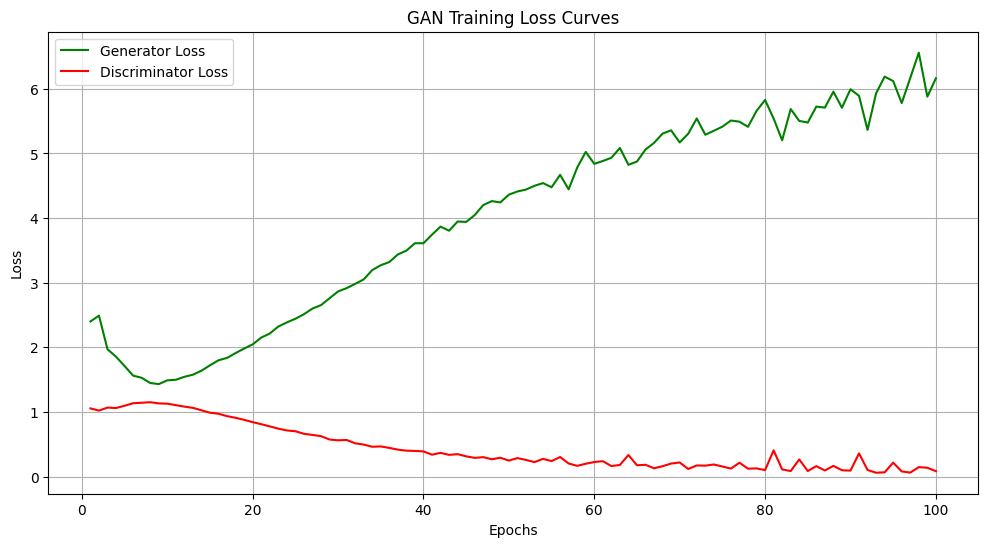

In [1]:
import matplotlib.pyplot as plt

# GAN training data
epochs = list(range(1, 101))
loss_g = [2.4008, 2.4908, 1.9702, 1.8548, 1.7109, 1.5626, 1.5292, 1.4487, 1.4317, 1.4898, 1.4988, 1.5447, 1.5770, 1.6390, 1.7223, 1.8004, 1.8373, 1.9118, 1.9818, 2.0463, 2.1515, 2.2142, 2.3220, 2.3863, 2.4429, 2.5125, 2.6004, 2.6536, 2.7598, 2.8651, 2.9168, 2.9819, 3.0519, 3.1953, 3.2710, 3.3203, 3.4376, 3.4962, 3.6112, 3.6108, 3.7446, 3.8682, 3.8048, 3.9474, 3.9409, 4.0468, 4.2016, 4.2628, 4.2425, 4.3623, 4.4120, 4.4412, 4.4997, 4.5415, 4.4770, 4.6690, 4.4450, 4.7817, 5.0241, 4.8393, 4.8832, 4.9329, 5.0848, 4.8244, 4.8749, 5.0614, 5.1635, 5.3074, 5.3578, 5.1700, 5.3053, 5.5411, 5.2896, 5.3506, 5.4146, 5.5097, 5.4913, 5.4120, 5.6582, 5.8277, 5.5398, 5.2039, 5.6875, 5.5033, 5.4787, 5.7250, 5.7091, 5.9565, 5.7068, 5.9935, 5.8907, 5.3637, 5.9310, 6.1887, 6.1199, 5.7791, 6.1680, 6.5584, 5.8789, 6.1621]
loss_d = [1.0562, 1.0220, 1.0683, 1.0616, 1.0967, 1.1355, 1.1432, 1.1516, 1.1331, 1.1290, 1.1057, 1.0832, 1.0644, 1.0266, 0.9892, 0.9731, 0.9359, 0.9106, 0.8787, 0.8432, 0.8115, 0.7778, 0.7424, 0.7147, 0.7026, 0.6628, 0.6455, 0.6265, 0.5744, 0.5622, 0.5673, 0.5159, 0.4962, 0.4627, 0.4674, 0.4445, 0.4179, 0.4019, 0.3978, 0.3901, 0.3397, 0.3678, 0.3370, 0.3477, 0.3143, 0.2903, 0.3017, 0.2690, 0.2928, 0.2481, 0.2875, 0.2586, 0.2251, 0.2750, 0.2408, 0.3034, 0.2035, 0.1671, 0.1996, 0.2266, 0.2389, 0.1643, 0.1809, 0.3350, 0.1762, 0.1834, 0.1296, 0.1613, 0.2026, 0.2193, 0.1183, 0.1732, 0.1703, 0.1878, 0.1574, 0.1242, 0.2159, 0.1227, 0.1281, 0.1011, 0.4064, 0.1121, 0.0864, 0.2664, 0.0867, 0.1628, 0.0954, 0.1665, 0.0989, 0.0933, 0.3598, 0.1032, 0.0607, 0.0666, 0.2165, 0.0809, 0.0626, 0.1475, 0.1378, 0.0849]

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_g, label='Generator Loss', color='green')
plt.plot(epochs, loss_d, label='Discriminator Loss', color='red')
plt.title('GAN Training Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Saving Checkpoints

In [ ]:
from google.colab import files
files.download('./vae_checkpoints/vae_epoch_50.pth')

In [ ]:
files.download('gan_last_checkpoint/gen_last.pt')
files.download('gan_last_checkpoint/disc_last.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Create the VAE directory in your Google Drive
!mkdir -p ./drive/MyDrive/VAE

# Create the GAN directory in your Google Drive
!mkdir -p ./drive/MyDrive/GAN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp vae_checkpoints/vae_epoch_50.pth ./drive/MyDrive/VAE/vae_last.pth
!cp gan_last_checkpoint/gen_last.pt ./drive/MyDrive/GAN/gen_last.pt
!cp gan_last_checkpoint/disc_last.pt ./drive/MyDrive/GAN/disc_last.pt

Taking Inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torchvision.datasets import CIFAR10

class ConvVAE(nn.Module):
    def __init__(self, z_dim=64):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
        )
        self.fc_mu     = nn.Linear(256 * 4 * 4, z_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, z_dim)
        self.fc_dec = nn.Linear(z_dim, 256 * 4 * 4)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        mu     = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, 256, 4, 4)
        x_hat = self.dec(h)
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model
z_dim = 64  # must match what you used
vae = ConvVAE(z_dim=z_dim).to(device)

# Load checkpoint
ckpt = torch.load('/content/drive/MyDrive/vae_epoch_50.pth', map_location=device)
vae.load_state_dict(ckpt)  # or if you saved just state_dict, load that

vae.eval()  # important for inference

# Prepare test data loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
test_ds = CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

to_pil = ToPILImage()

# --- Inference 1: Reconstructions ---
with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x.to(device)[:8]
    x_hat, mu, logvar = vae(x)
    # Convert x & x_hat back to images in [0,1]
    x = x.cpu().clamp(-1,1)
    x = (x + 1)/2
    x_hat = x_hat.cpu().clamp(-1,1)
    x_hat = (x_hat + 1)/2

    os.makedirs('vae_inference', exist_ok=True)
    for i in range(8):
        to_pil(x[i]).save(f"vae_inference/orig_{i}.png")
        to_pil(x_hat[i]).save(f"vae_inference/recon_{i}.png")

# --- Inference 2: Sampling from prior ---
with torch.no_grad():
    n_samples = 8
    z = torch.randn(n_samples, z_dim, device=device)
    samples = vae.decode(z)
    samples = samples.cpu().clamp(-1,1)
    samples = (samples + 1)/2
    os.makedirs('vae_inference/samples', exist_ok=True)
    for i in range(n_samples):
        to_pil(samples[i]).save(f"vae_inference/sample_{i}.png")


100%|██████████| 170M/170M [00:19<00:00, 8.94MB/s]


In [ ]:
# Define your Generator class exactly as in training
class Generator(nn.Module):
    def __init__(self, z_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512,256,4,2,1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256,128,4,2,1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64,4,2,1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64,3,3,1,1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.net(z)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate generator
z_dim = 128  # same as used in training
generator = Generator(z_dim=z_dim).to(device)

# Load checkpoint
ckpt = torch.load('/content/drive/MyDrive/gen_last.pt', map_location=device)
generator.load_state_dict(ckpt)  # or ckpt['model_state'] etc depending on how you saved

generator.eval()

# Inference: sample new images
to_pil = ToPILImage()

n_samples = 8
with torch.no_grad():
    z = torch.randn(n_samples, z_dim, device=device)
    fake = generator(z)
    fake = fake.cpu().clamp(-1,1)
    fake = (fake + 1)/2

    os.makedirs('gan_inference', exist_ok=True)
    for i in range(n_samples):
        to_pil(fake[i]).save(f"gan_inference/sample_{i}.png")


In [ ]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 test set
transform = transforms.Compose([
    transforms.ToTensor()
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)


In [ ]:
# Load VAE + GAN
vae = ConvVAE().to(device)
vae.load_state_dict(torch.load("/content/drive/MyDrive/vae_epoch_50.pth", map_location=device))
vae.eval()

generator = Generator().to(device)
generator.load_state_dict(torch.load("/content/drive/MyDrive/gen_last.pt", map_location=device))
generator.eval()

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Tanh()
  )
)

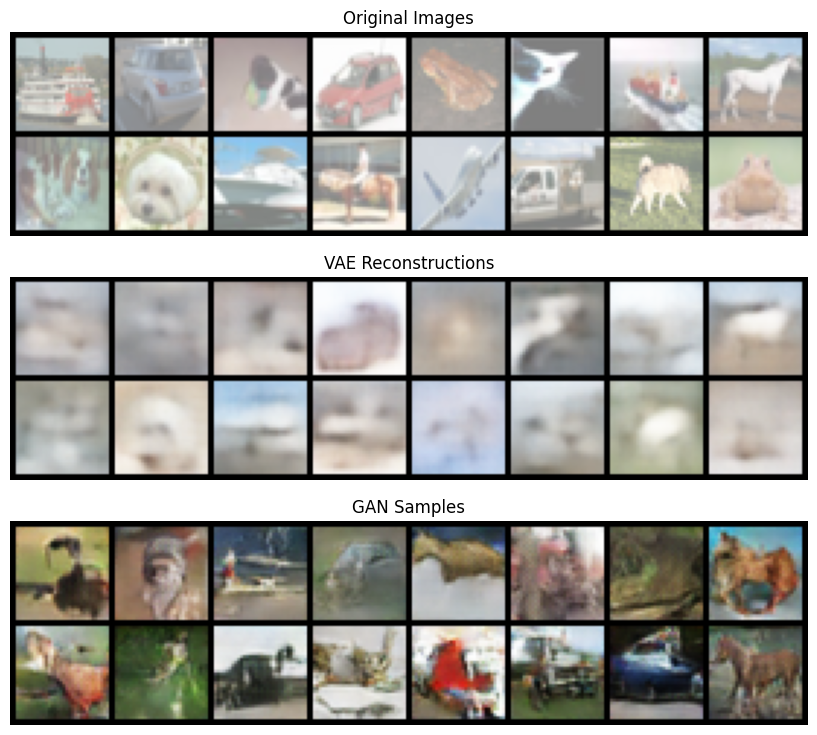

In [ ]:
# Get a batch of test images
images, _ = next(iter(testloader))
images = images.to(device)

# VAE reconstructions
with torch.no_grad():
    mu, logvar = vae.encode(images)
    z = vae.reparameterize(mu, logvar)
    vae_recon = vae.decode(z)

# GAN samples
noise = torch.randn(images.size(0), 128, device=device) # Change 100 to 128
with torch.no_grad():
    gan_samples = generator(noise)

# Denormalize (if needed)
def denorm(x):
    return (x.clamp(-1, 1) + 1) / 2

# Plot
fig, axes = plt.subplots(3, 1, figsize=(12, 9))
axes[0].imshow(make_grid(denorm(images.cpu()), nrow=8).permute(1,2,0))
axes[0].set_title("Original Images"); axes[0].axis("off")

axes[1].imshow(make_grid(denorm(vae_recon.cpu()), nrow=8).permute(1,2,0))
axes[1].set_title("VAE Reconstructions"); axes[1].axis("off")

axes[2].imshow(make_grid(denorm(gan_samples.cpu()), nrow=8).permute(1,2,0))
axes[2].set_title("GAN Samples"); axes[2].axis("off")

plt.show()


In [ ]:
mse_loss = F.mse_loss(vae_recon, images).item()
print(f"VAE Reconstruction MSE: {mse_loss:.6f}")


VAE Reconstruction MSE: 0.018269


In [ ]:
# ! pip install pytorch-fid

In [ ]:
# Helper: save images to temp folder
def save_images_to_folder(images, folder):
    os.makedirs(folder, exist_ok=True)
    for i, img in enumerate(images):
        save_image(denorm(img), os.path.join(folder, f"{i}.png"))

# Generate sets
real_folder = "./fid_real"
vae_folder = "./fid_vae"
gan_folder = "./fid_gan"

save_images_to_folder(images.cpu(), real_folder)
save_images_to_folder(vae_recon.cpu(), vae_folder)
save_images_to_folder(gan_samples.cpu(), gan_folder)

# Compute FID
fid_vae = fid_score.calculate_fid_given_paths([real_folder, vae_folder], batch_size=16, device=device, dims=2048)
fid_gan = fid_score.calculate_fid_given_paths([real_folder, gan_folder], batch_size=16, device=device, dims=2048)

print(f"FID (VAE vs Real): {fid_vae:.2f}")
print(f"FID (GAN vs Real): {fid_gan:.2f}")


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth


100%|██████████| 91.2M/91.2M [00:00<00:00, 106MB/s]
100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


FID (VAE vs Real): 350.87
FID (GAN vs Real): 309.71


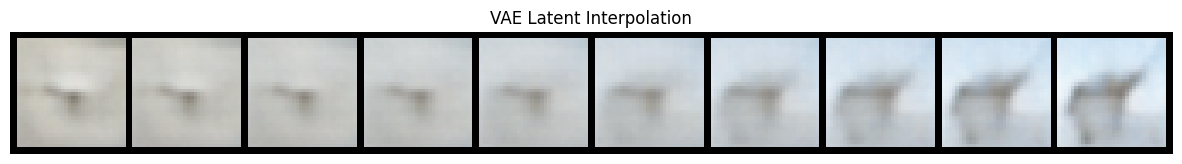

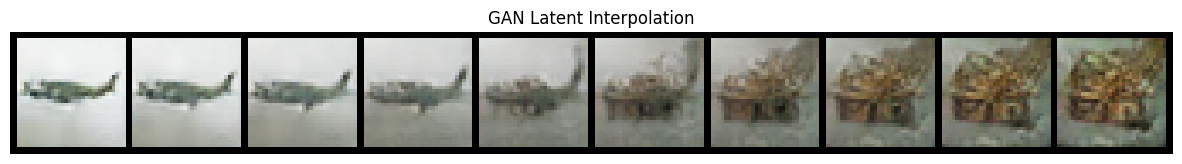

In [ ]:
def denorm(x):
    return (x.clamp(-1, 1) + 1) / 2

# Define your Generator class exactly as in training (Added this block)
class Generator(nn.Module):
    def __init__(self, z_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512,256,4,2,1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256,128,4,2,1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64,4,2,1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64,3,3,1,1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.net(z)


# --- VAE Interpolation ---
def interpolate_vae(img1, img2, steps=10):
    vae.eval()
    with torch.no_grad():
        mu1, logvar1 = vae.encode(img1.unsqueeze(0).to(device))
        z1 = vae.reparameterize(mu1, logvar1)

        mu2, logvar2 = vae.encode(img2.unsqueeze(0).to(device))
        z2 = vae.reparameterize(mu2, logvar2)

        # linear interpolation between z1 and z2
        alphas = torch.linspace(0, 1, steps).to(device)
        z_interp = torch.stack([(1-a)*z1 + a*z2 for a in alphas]).squeeze(1) # Squeeze to remove the extra dimension
        recon = vae.decode(z_interp).cpu()
    return recon

# --- GAN Interpolation ---
def interpolate_gan(latent_dim=128, steps=10):
    generator.eval()
    with torch.no_grad():
        z1 = torch.randn(1, latent_dim, device=device)
        z2 = torch.randn(1, latent_dim, device=device)

        alphas = torch.linspace(0, 1, steps).to(device)
        # Stack the interpolated latent vectors correctly
        z_interp = torch.stack([(1-a)*z1 + a*z2 for a in alphas]).squeeze(1)
        samples = generator(z_interp).cpu()
    return samples

# Pick two test images from CIFAR-10
test_iter = iter(testloader)
images, _ = next(test_iter)
img1, img2 = images[0], images[1]

vae_interp = interpolate_vae(img1, img2, steps=10)
gan_interp = interpolate_gan(latent_dim=128, steps=10)

# Plot VAE interpolation
plt.figure(figsize=(15,3))
plt.imshow(make_grid(denorm(vae_interp), nrow=10).permute(1,2,0))
plt.axis("off"); plt.title("VAE Latent Interpolation"); plt.show()

# Plot GAN interpolation
plt.figure(figsize=(15,3))
plt.imshow(make_grid(denorm(gan_interp), nrow=10).permute(1,2,0))
plt.axis("off"); plt.title("GAN Latent Interpolation"); plt.show()

Latent shape: (1632, 64)


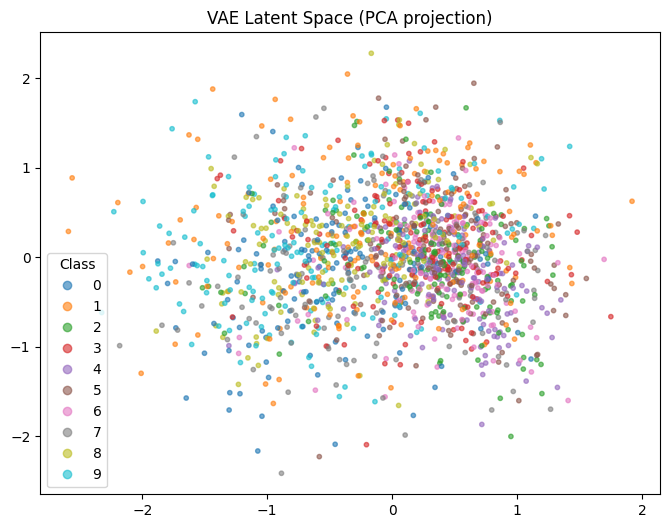

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1632 samples in 0.001s...
[t-SNE] Computed neighbors for 1632 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1632
[t-SNE] Computed conditional probabilities for sample 1632 / 1632
[t-SNE] Mean sigma: 0.949540
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.034142
[t-SNE] KL divergence after 2000 iterations: 2.708375


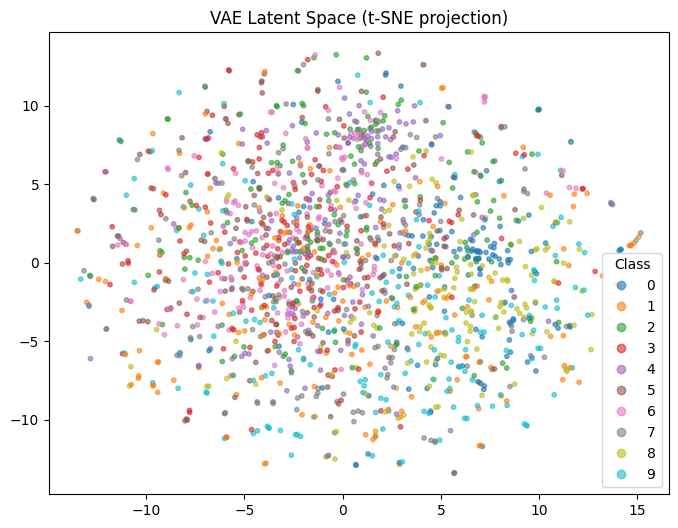

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

vae.eval()

# Collect latent vectors & labels
latents = []
labels = []

with torch.no_grad():
    for i, (imgs, labs) in enumerate(testloader):
        imgs = imgs.to(device)
        mu, logvar = vae.encode(imgs)
        z = mu  # use mean of q(z|x)
        latents.append(z.cpu().numpy())
        labels.append(labs.numpy())
        if i > 100:   # limit ~1000 images
            break

latents = np.concatenate(latents, axis=0)
labels = np.concatenate(labels, axis=0)

print("Latent shape:", latents.shape)  # (N, latent_dim)

# --- PCA to 2D ---
pca = PCA(n_components=2)
z_pca = pca.fit_transform(latents)

plt.figure(figsize=(8,6))
scatter = plt.scatter(z_pca[:,0], z_pca[:,1], c=labels, cmap="tab10", alpha=0.6, s=10)
plt.legend(*scatter.legend_elements(), title="Class")
plt.title("VAE Latent Space (PCA projection)")
plt.show()

# --- t-SNE (slower but more non-linear separation) ---
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, verbose=1)
z_tsne = tsne.fit_transform(latents)

plt.figure(figsize=(8,6))
scatter = plt.scatter(z_tsne[:,0], z_tsne[:,1], c=labels, cmap="tab10", alpha=0.6, s=10)
plt.legend(*scatter.legend_elements(), title="Class")
plt.title("VAE Latent Space (t-SNE projection)")
plt.show()


Latent dim: 64


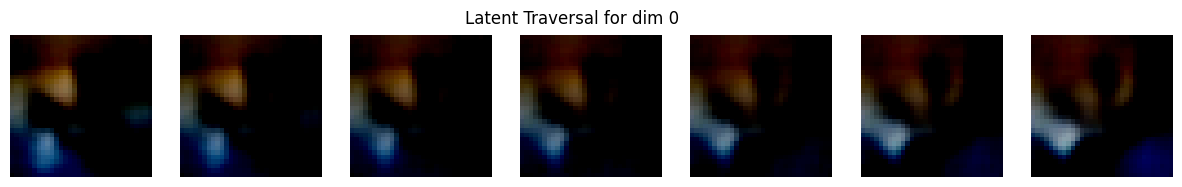

In [ ]:
vae.eval()

# Take a single image
imgs, _ = next(iter(test_loader))
img = imgs[0].unsqueeze(0).to(device)

with torch.no_grad():
    mu, logvar = vae.encode(img)
    z = mu[0].cpu().numpy()

latent_dim = len(z)
print("Latent dim:", latent_dim)

# Choose a dimension to vary (try several)
dim_to_vary = 0

# Create variations
n_steps = 7
values = np.linspace(-3, 3, n_steps)   # range of variation
images = []

for v in values:
    z_new = z.copy()
    z_new[dim_to_vary] = v
    z_new_tensor = torch.tensor(z_new, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        img_dec = vae.decode(z_new_tensor).cpu()
    images.append(img_dec)

# Plot
fig, axes = plt.subplots(1, n_steps, figsize=(15, 2))
for i, ax in enumerate(axes):
    ax.imshow(np.transpose(images[i][0].numpy(), (1,2,0)))
    ax.axis("off")
plt.suptitle(f"Latent Traversal for dim {dim_to_vary}")
plt.show()


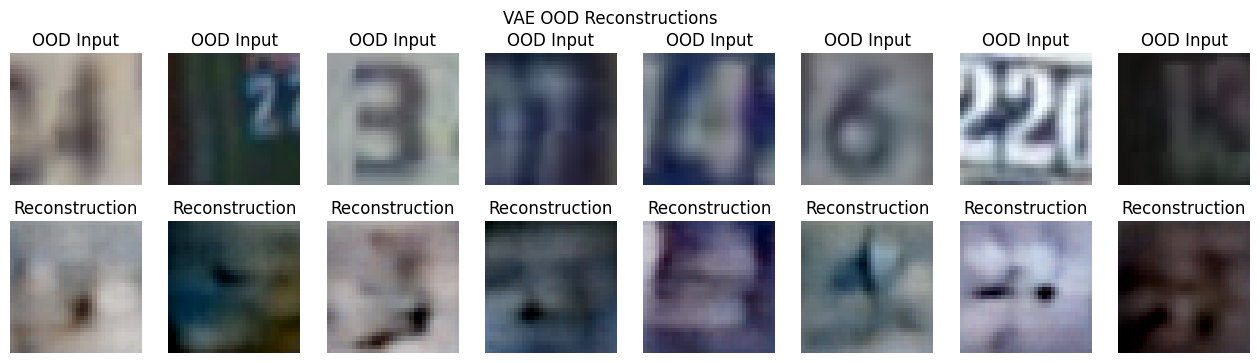

In-Distribution (CIFAR-10) recon error: 0.0402
OOD (SVHN) recon error: 0.0106


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

vae.eval()

# --- Load OOD dataset (SVHN in this case) ---
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

ood_dataset = torchvision.datasets.SVHN(root="./data", split='test', download=True, transform=transform)
ood_loader = torch.utils.data.DataLoader(ood_dataset, batch_size=16, shuffle=True)

# --- Get a batch of OOD images ---
ood_imgs, _ = next(iter(ood_loader))
ood_imgs = ood_imgs.to(device)

# --- Run through VAE ---
with torch.no_grad():
    recon, mu, logvar = vae(ood_imgs)

# --- Show original vs reconstruction ---
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axes[0, i].imshow(np.transpose(ood_imgs[i].cpu().numpy(), (1,2,0)))
    axes[0, i].axis("off")
    axes[0, i].set_title("OOD Input")

    axes[1, i].imshow(np.transpose(recon[i].cpu().numpy(), (1,2,0)))
    axes[1, i].axis("off")
    axes[1, i].set_title("Reconstruction")
plt.suptitle("VAE OOD Reconstructions")
plt.show()

# --- Compute reconstruction error ---
id_imgs, _ = next(iter(test_loader))   # in-distribution (CIFAR-10 test)
id_imgs = id_imgs.to(device)
with torch.no_grad():
    recon_id, _, _ = vae(id_imgs)

mse = torch.nn.MSELoss(reduction="mean")
ood_error = mse(recon, ood_imgs).item()
id_error = mse(recon_id, id_imgs).item()

print(f"In-Distribution (CIFAR-10) recon error: {id_error:.4f}")
print(f"OOD (SVHN) recon error: {ood_error:.4f}")


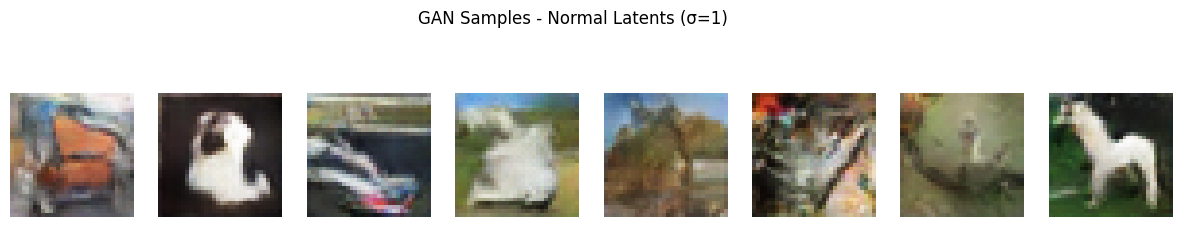

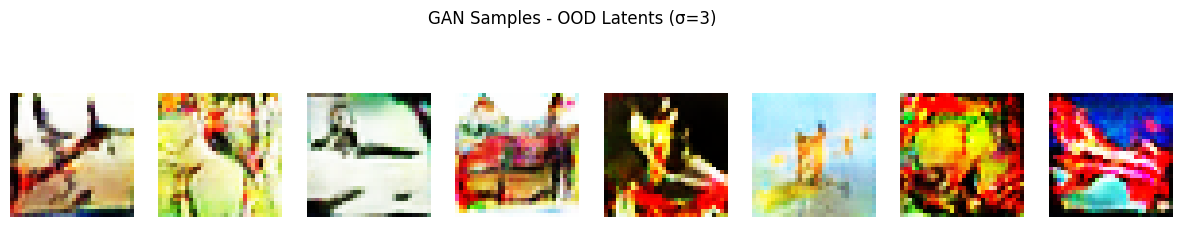

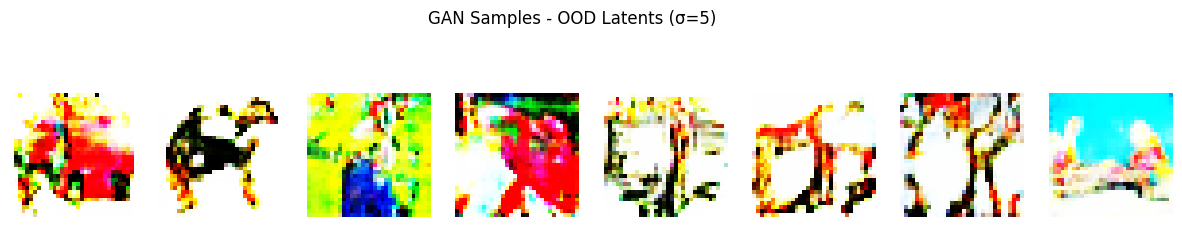

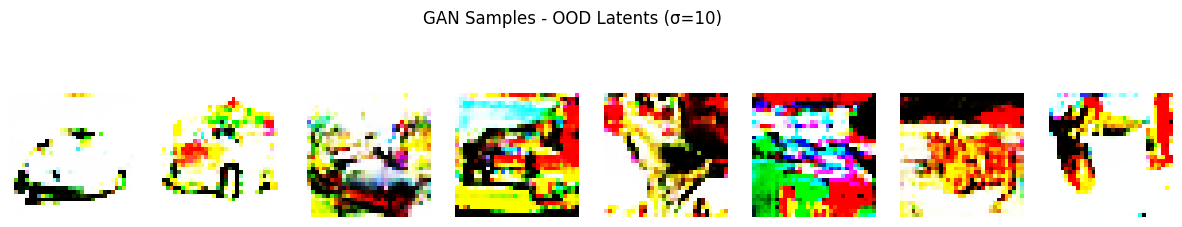

In [ ]:
generator.eval()

def show_generated(samples, title):
    samples = (samples.clamp(-1, 1) + 1) / 2.0  # denormalize from [-1,1] to [0,1]
    samples = samples.cpu().detach().numpy()
    fig, axes = plt.subplots(1, len(samples), figsize=(15,3))
    for i, img in enumerate(samples):
        axes[i].imshow(np.transpose(img, (1,2,0)))
        axes[i].axis("off")
    plt.suptitle(title)
    plt.show()

# Normal latent distribution (in-distribution)
z_normal = torch.randn(8, 128, 1, 1, device=device)  # latent dim = 128 (adjust if different)
with torch.no_grad():
    gen_normal = generator(z_normal)
show_generated(gen_normal, "GAN Samples - Normal Latents (σ=1)")

# OOD Latents with higher variance
for sigma in [3, 5, 10]:
    z_ood = torch.randn(8, 128, 1, 1, device=device) * sigma # latent dim = 128 (adjust if different)
    with torch.no_grad():
        gen_ood = generator(z_ood)
    show_generated(gen_ood, f"GAN Samples - OOD Latents (σ={sigma})")

Device: cuda


100%|██████████| 169M/169M [00:04<00:00, 41.8MB/s]


Computing ID errors (CIFAR-10 test)...
Computing OOD errors (SVHN)...
Computing OOD errors (CIFAR-100)...
ROC AUC (CIFAR-10 vs SVHN) = 0.0812
ROC AUC (CIFAR-10 vs CIFAR-100) = 0.5120


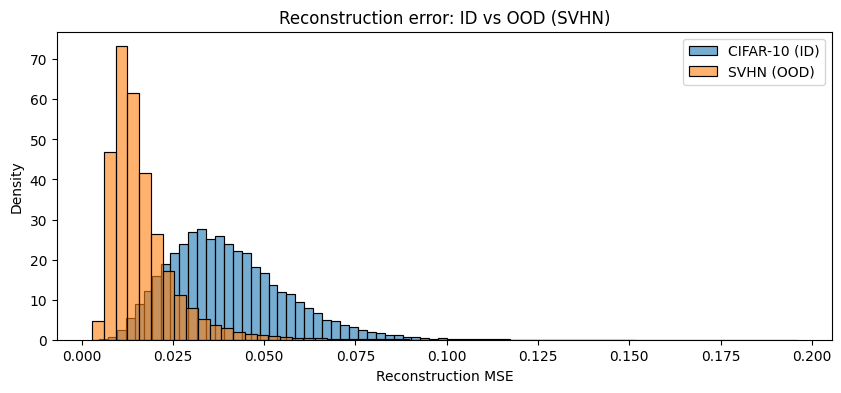

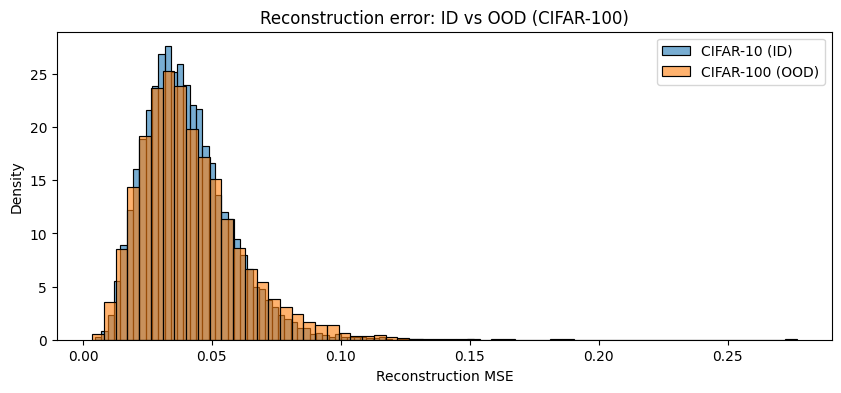

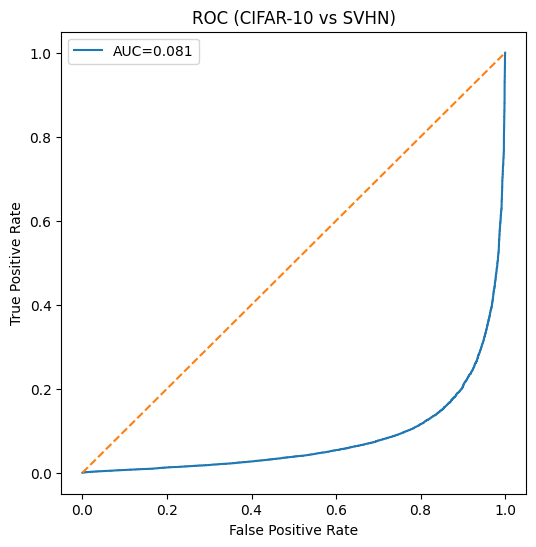

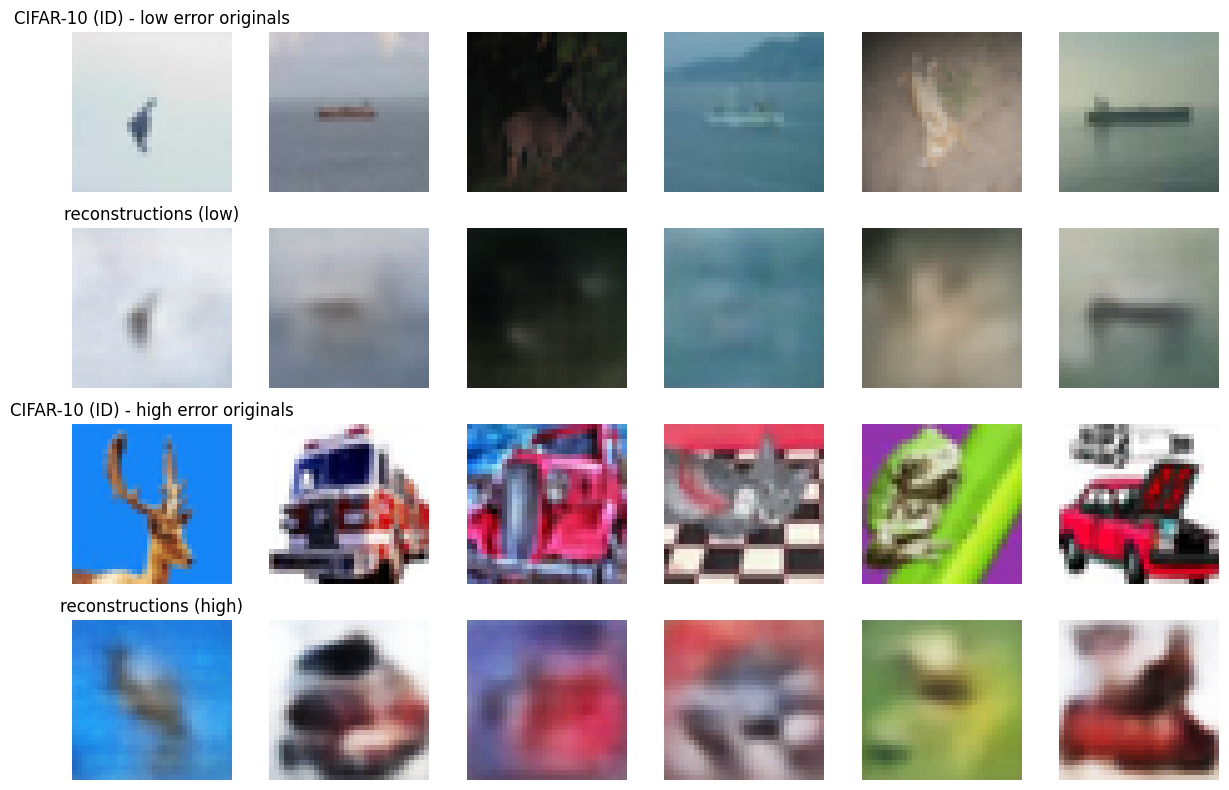

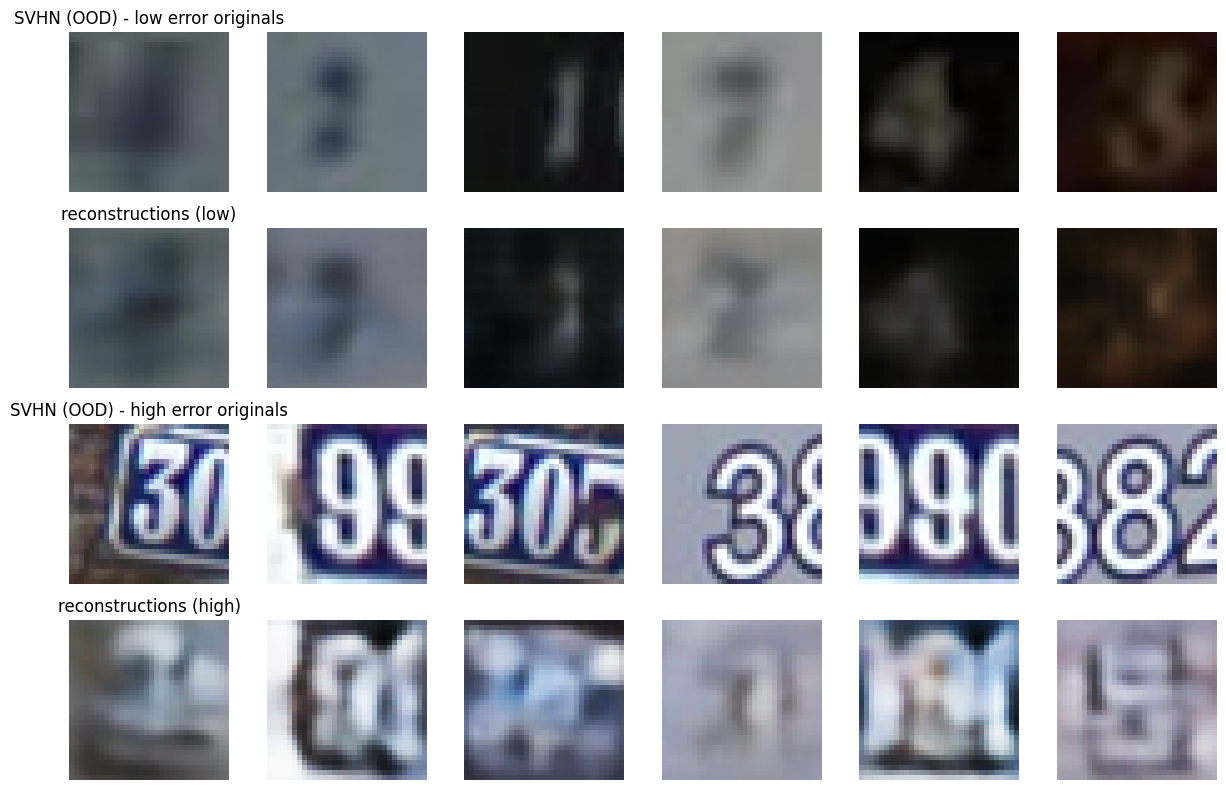

In [ ]:
# ====== VAE anomaly detection (ID vs OOD) ======
# Paste this cell into Colab and run.
import torch, os, numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# ---------- Utility: denorm for plotting ----------
def denorm(t):
    return (t.clamp(-1,1) + 1) / 2

# ---------- Load your VAE model (must match architecture) ----------
# Replace with your ConvVAE class if needed.
# from your_module import ConvVAE  # or define ConvVAE above
z_dim = 64  # change if different
vae = ConvVAE(z_dim=z_dim).to(device)   # ensure ConvVAE is defined in the notebook
ckpt = torch.load('/content/drive/MyDrive/vae_epoch_50.pth', map_location=device)
# ckpt contains keys -> adapt as needed:
if 'state_dict' in ckpt:
    vae.load_state_dict(ckpt)
else:
    # maybe you saved only state_dict
    vae.load_state_dict(ckpt)
vae.eval()

# ---------- Datasets: ID and OOD ----------
# Note: transforms must match training normalization
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# In-distribution: CIFAR-10 test
id_ds = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
id_loader = DataLoader(id_ds, batch_size=128, shuffle=False, num_workers=2)

# OOD set 1: SVHN (digits) - a common OOD for CIFAR
ood1_ds = datasets.SVHN(root='./data', split='test', download=True, transform=transform)
ood1_loader = DataLoader(ood1_ds, batch_size=128, shuffle=False, num_workers=2)

# OOD set 2: CIFAR-100 (similar but different classes)
ood2_ds = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
ood2_loader = DataLoader(ood2_ds, batch_size=128, shuffle=False, num_workers=2)

# ---------- Scoring function ----------
mse_loss = torch.nn.MSELoss(reduction='none')  # compute per-pixel
def recon_errors(loader, max_batches=None):
    errors = []
    originals = []
    reconstructions = []
    with torch.no_grad():
        for i, (imgs, *_ ) in enumerate(loader):
            imgs = imgs.to(device)
            x_hat, mu, logvar = vae(imgs)    # forward: change if your VAE returns differently
            # compute per-sample MSE (average over pixels and channels)
            per_pixel = mse_loss(x_hat, imgs)            # shape [B,C,H,W]
            per_sample = per_pixel.view(per_pixel.size(0), -1).mean(dim=1).cpu().numpy()
            errors.append(per_sample)
            # keep some examples for visualization
            originals.append(imgs.cpu())
            reconstructions.append(x_hat.cpu())
            if max_batches and (i+1) >= max_batches:
                break
    errors = np.concatenate(errors, axis=0)
    originals = torch.cat(originals, dim=0)
    reconstructions = torch.cat(reconstructions, dim=0)
    return errors, originals, reconstructions

# ---------- Collect scores ----------
# To speed up, limit max_batches (set None to compute for entire sets)
max_batches = None
print("Computing ID errors (CIFAR-10 test)...")
id_errors, id_orig, id_recon = recon_errors(id_loader, max_batches=max_batches)
print("Computing OOD errors (SVHN)...")
ood1_errors, ood1_orig, ood1_recon = recon_errors(ood1_loader, max_batches=max_batches)
print("Computing OOD errors (CIFAR-100)...")
ood2_errors, ood2_orig, ood2_recon = recon_errors(ood2_loader, max_batches=max_batches)

# ---------- Combine and evaluate ----------
y_true = np.concatenate([np.zeros_like(id_errors), np.ones_like(ood1_errors)])   # 0=ID, 1=OOD
scores = np.concatenate([id_errors, ood1_errors])
roc_auc = roc_auc_score(y_true, scores)
fpr, tpr, thresholds = roc_curve(y_true, scores)

print(f"ROC AUC (CIFAR-10 vs SVHN) = {roc_auc:.4f}")

# Also evaluate CIFAR-10 vs CIFAR-100
y_true2 = np.concatenate([np.zeros_like(id_errors), np.ones_like(ood2_errors)])
scores2 = np.concatenate([id_errors, ood2_errors])
roc_auc2 = roc_auc_score(y_true2, scores2)
print(f"ROC AUC (CIFAR-10 vs CIFAR-100) = {roc_auc2:.4f}")

# ---------- Plot histograms ----------
plt.figure(figsize=(10,4))
sns.histplot(id_errors, label='CIFAR-10 (ID)', stat='density', color=None, alpha=0.6, bins=60)
sns.histplot(ood1_errors, label='SVHN (OOD)', stat='density', color=None, alpha=0.6, bins=60)
plt.legend(); plt.xlabel("Reconstruction MSE"); plt.title("Reconstruction error: ID vs OOD (SVHN)")
plt.savefig("recon_error_hist_svhn.png", bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(id_errors, label='CIFAR-10 (ID)', stat='density', color=None, alpha=0.6, bins=60)
sns.histplot(ood2_errors, label='CIFAR-100 (OOD)', stat='density', color=None, alpha=0.6, bins=60)
plt.legend(); plt.xlabel("Reconstruction MSE"); plt.title("Reconstruction error: ID vs OOD (CIFAR-100)")
plt.savefig("recon_error_hist_cifar100.png", bbox_inches='tight')
plt.show()

# ---------- Plot ROC curve (CIFAR-10 vs SVHN) ----------
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC (CIFAR-10 vs SVHN)")
plt.legend()
plt.savefig("roc_svhn.png", bbox_inches='tight')
plt.show()

# ---------- Show example images: low vs high error ----------
def show_examples(orig_tensor, recon_tensor, errors, title_prefix, n=6):
    # pick n lowest and n highest error examples
    idx_sorted = np.argsort(errors)
    low_idx = idx_sorted[:n]
    high_idx = idx_sorted[-n:]
    # plot a grid: originals (low), reconstructions (low), originals (high), reconstructions (high)
    fig, axes = plt.subplots(4, n, figsize=(n*2, 8))
    for j, ix in enumerate(low_idx):
        axes[0,j].imshow(np.transpose(denorm(orig_tensor[ix]).numpy(), (1,2,0)))
        axes[0,j].axis('off')
        axes[1,j].imshow(np.transpose(denorm(recon_tensor[ix]).numpy(), (1,2,0)))
        axes[1,j].axis('off')
    for j, ix in enumerate(high_idx):
        axes[2,j].imshow(np.transpose(denorm(orig_tensor[ix]).numpy(), (1,2,0)))
        axes[2,j].axis('off')
        axes[3,j].imshow(np.transpose(denorm(recon_tensor[ix]).numpy(), (1,2,0)))
        axes[3,j].axis('off')
    axes[0,0].set_title(f"{title_prefix} - low error originals")
    axes[1,0].set_title("reconstructions (low)")
    axes[2,0].set_title(f"{title_prefix} - high error originals")
    axes[3,0].set_title("reconstructions (high)")
    plt.tight_layout()
    return fig

fig1 = show_examples(id_orig, id_recon, id_errors, "CIFAR-10 (ID)", n=6)
fig1.savefig("examples_id.png", bbox_inches='tight')
plt.show()

fig2 = show_examples(ood1_orig, ood1_recon, ood1_errors, "SVHN (OOD)", n=6)
fig2.savefig("examples_svhn.png", bbox_inches='tight')
plt.show()


Task 5

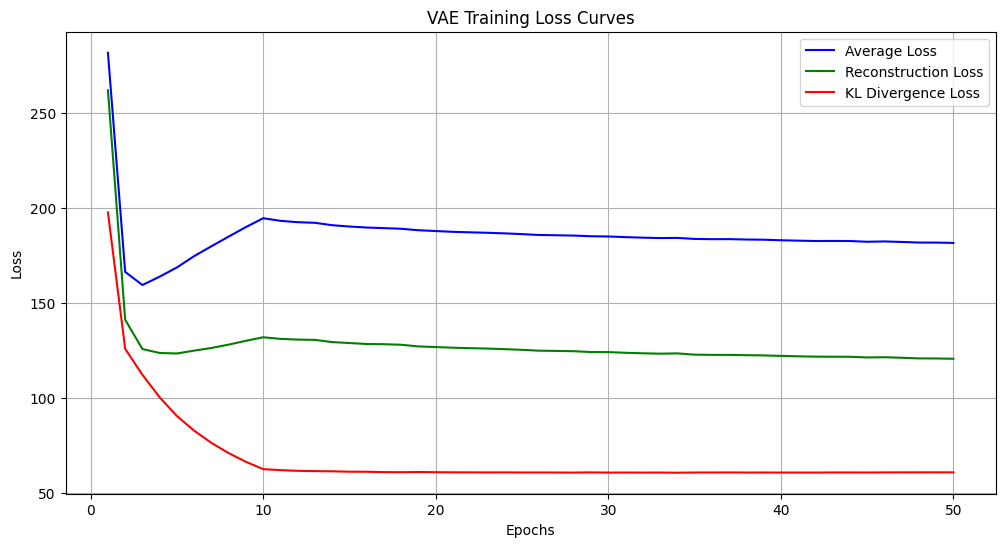

In [ ]:
import matplotlib.pyplot as plt

# Loss values extracted from your logs
epochs = list(range(1, 51))

avg_loss = [
281.423799,166.246520,159.347108,163.739159,168.589428,
174.535092,179.717563,184.803929,189.799766,194.446177,
193.076860,192.351373,192.040984,190.769632,190.077198,
189.542306,189.245153,188.893945,188.122650,187.712853,
187.293521,187.032394,186.780116,186.485909,186.088022,
185.633746,185.497133,185.320557,184.975712,184.842417,
184.512986,184.223632,184.025531,184.094611,183.566005,
183.425286,183.461458,183.252545,183.151386,182.874211,
182.658067,182.470105,182.487424,182.466318,182.071167,
182.248260,181.977073,181.664856,181.632683,181.466646
]

recon_loss = [
261.671831,141.084078,125.703607,123.617295,123.356484,
124.869248,126.263711,128.017343,130.028045,131.881204,
131.026854,130.666829,130.506504,129.339326,128.845628,
128.344905,128.237301,127.937997,127.065004,126.743776,
126.388399,126.153251,125.938698,125.623939,125.270527,
124.814973,124.700686,124.560240,124.108167,124.080504,
123.716436,123.459856,123.249264,123.403551,122.756016,
122.615021,122.610169,122.467139,122.348551,122.092444,
121.872734,121.696854,121.653946,121.628373,121.270039,
121.390515,121.103505,120.778340,120.733868,120.591852
]

kl_loss = [
197.519683,125.812209,112.145000,100.304659,90.465887,
82.776402,76.362647,70.983231,66.413026,62.564973,
62.050007,61.684544,61.534480,61.430305,61.231569,
61.197401,61.007852,60.955948,61.057646,60.969077,
60.905122,60.879142,60.841419,60.861969,60.817496,
60.818773,60.796447,60.760317,60.867545,60.761913,
60.796549,60.763776,60.776267,60.691060,60.809989,
60.810266,60.851289,60.785406,60.802835,60.781767,
60.785332,60.773251,60.833478,60.837944,60.801128,
60.857744,60.873568,60.886516,60.898815,60.874794
]

# Plotting
plt.figure(figsize=(12,6))
plt.plot(epochs, avg_loss, label="Average Loss", color="blue")
plt.plot(epochs, recon_loss, label="Reconstruction Loss", color="green")
plt.plot(epochs, kl_loss, label="KL Divergence Loss", color="red")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("VAE Training Loss Curves")
plt.legend()
plt.grid(True)
plt.show()


Question 3

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.9 MB/s eta 0:00:00
Device: cuda
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 45.3MiB/s]


Class embeddings shape: torch.Size([10, 512])
Zero-Shot CLIP Accuracy on CIFAR-10: 89.24%

Classification Report:
              precision    recall  f1-score   support

    airplane     0.9532    0.8970    0.9243      1000
  automobile     0.9353    0.9250    0.9301      1000
        bird     0.8336    0.8870    0.8595      1000
         cat     0.8190    0.8640    0.8409      1000
        deer     0.9132    0.8000    0.8529      1000
         dog     0.8529    0.8870    0.8696      1000
        frog     0.9726    0.7820    0.8670      1000
       horse     0.8351    0.9720    0.8983      1000
        ship     0.9294    0.9610    0.9449      1000
       truck     0.9187    0.9490    0.9336      1000

    accuracy                         0.8924     10000
   macro avg     0.8963    0.8924    0.8921     10000
weighted avg     0.8963    0.8924    0.8921     10000



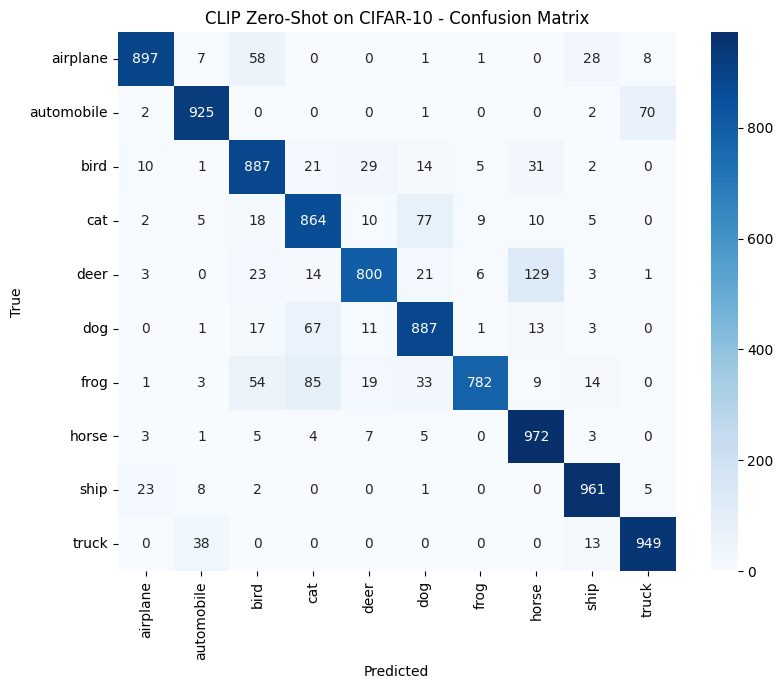

In [ ]:
# ====================================================
# CLIP Zero-Shot Evaluation on CIFAR-10 in Google Colab
# ====================================================

!pip install git+https://github.com/openai/CLIP.git ftfy regex tqdm seaborn --quiet

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

import clip
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# 1. Setup
# ------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# CIFAR-10 test loader
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor()
])
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)
classnames = testset.classes
print("Classes:", classnames)

# Load CLIP model
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# ------------------------------
# 2. Build text embeddings
# ------------------------------
templates = [
    "a photo of a {}.",
    "a picture of a {}.",
    "a photo of the {}.",
    "a blurry photo of a {}.",
    "a cropped photo of the {}.",
    "a rendering of a {}."
]

def compute_text_embeddings(model, classnames, templates):
    texts = []
    class_ranges = []
    for cname in classnames:
        prompts = [t.format(cname) for t in templates]
        class_ranges.append((len(texts), len(texts) + len(prompts)))
        texts.extend(prompts)

    with torch.no_grad():
        tokenized = clip.tokenize(texts).to(device)
        text_embeds = model.encode_text(tokenized)
        text_embeds /= text_embeds.norm(dim=-1, keepdim=True)

    # average prompts per class
    class_embeds = []
    for (s, e) in class_ranges:
        emb = text_embeds[s:e].mean(dim=0)
        emb /= emb.norm()
        class_embeds.append(emb)
    return torch.stack(class_embeds, dim=0)

class_embeddings = compute_text_embeddings(clip_model, classnames, templates)
print("Class embeddings shape:", class_embeddings.shape)

# ------------------------------
# 3. Zero-shot evaluation
# ------------------------------
def eval_clip(model, dataloader, class_embeddings):
    preds, trues = [], []
    model.eval()
    clip_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=device).view(1,3,1,1)
    clip_std = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=device).view(1,3,1,1)

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            images = (images - clip_mean) / clip_std

            img_embeds = model.encode_image(images)
            img_embeds /= img_embeds.norm(dim=-1, keepdim=True)

            sims = img_embeds @ class_embeddings.t()  # cosine similarity
            batch_preds = sims.argmax(dim=-1).cpu().numpy()
            preds.extend(batch_preds)
            trues.extend(labels.numpy())
    return np.array(trues), np.array(preds)

y_true, y_pred = eval_clip(clip_model, testloader, class_embeddings)

# ------------------------------
# 4. Metrics & plots
# ------------------------------
acc = accuracy_score(y_true, y_pred)
print(f"Zero-Shot CLIP Accuracy on CIFAR-10: {acc*100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classnames, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classnames, yticklabels=classnames, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CLIP Zero-Shot on CIFAR-10 - Confusion Matrix")
plt.show()


In [ ]:
# =========================================
# Prompt Engineering / Few-Shot Evaluation
# =========================================

prompt_sets = {
    "simple": ["{}"],
    "photo": ["a photo of a {}.", "a picture of a {}.", "a photo of the {}."],
    "detailed": [
        "a blurry photo of a {}.",
        "a cropped photo of a {}.",
        "a low-resolution photo of a {}.",
        "a photo of a {0}, {0}."  # fixed duplication
    ],
    "sketch": ["a sketch of a {}.", "a drawing of a {}.", "a cartoon of a {}."]
}
results = {}

for name, templates in prompt_sets.items():
    print(f"\n=== Evaluating prompt set: {name} ===")
    class_embeds = compute_text_embeddings(clip_model, classnames, templates)
    y_true, y_pred = eval_clip(clip_model, testloader, class_embeds)
    acc = accuracy_score(y_true, y_pred)
    results[name] = acc * 100
    print(f"Accuracy with '{name}' prompts: {acc*100:.2f}%")

# Show comparison
print("\nPrompt Engineering Results:")
for k, v in results.items():
    print(f"{k:10s} : {v:.2f}%")



=== Evaluating prompt set: simple ===
Accuracy with 'simple' prompts: 87.44%

=== Evaluating prompt set: photo ===
Accuracy with 'photo' prompts: 88.85%

=== Evaluating prompt set: detailed ===
Accuracy with 'detailed' prompts: 88.99%

=== Evaluating prompt set: sketch ===
Accuracy with 'sketch' prompts: 89.79%

Prompt Engineering Results:
simple     : 87.44%
photo      : 88.85%
detailed   : 88.99%
sketch     : 89.79%


Sampled classes: ['automobile', 'ship', 'cat', 'cat', 'truck', 'truck', 'horse', 'ship', 'bird', 'bird', 'dog', 'deer', 'ship', 'horse', 'frog', 'automobile', 'cat', 'truck', 'truck', 'ship']

=== Text-to-Image Retrieval ===

Query: a photo of a cat
  Top-1: image idx=9839 class=cat
  Top-2: image idx=1518 class=cat
  Top-3: image idx=8183 class=cat


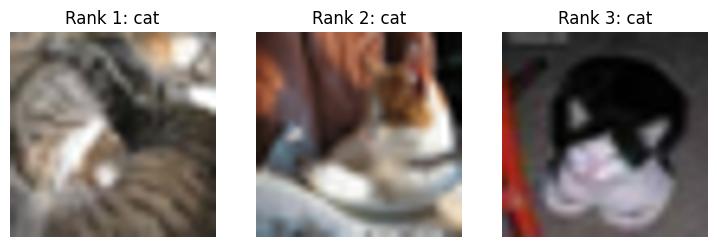


Query: a photo of a dog
  Top-1: image idx=3719 class=dog
  Top-2: image idx=8457 class=bird
  Top-3: image idx=9318 class=deer


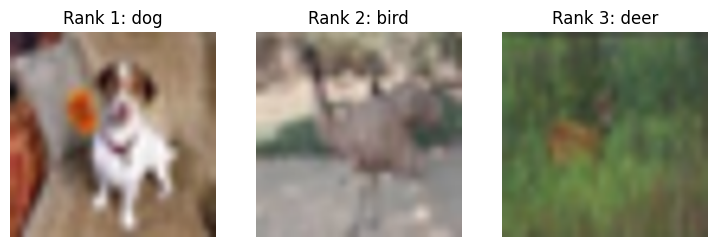


Query: a photo of a car
  Top-1: image idx=8032 class=automobile
  Top-2: image idx=3181 class=truck
  Top-3: image idx=7225 class=automobile


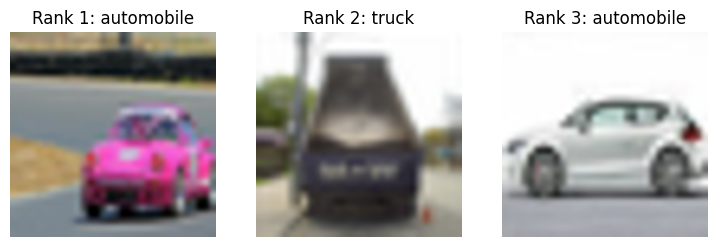


Query: a photo of an airplane
  Top-1: image idx=5868 class=truck
  Top-2: image idx=9318 class=deer
  Top-3: image idx=8457 class=bird


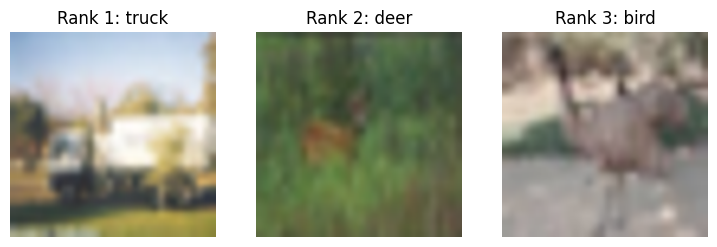


Query: a photo of a ship
  Top-1: image idx=8146 class=ship
  Top-2: image idx=2600 class=ship
  Top-3: image idx=8892 class=ship


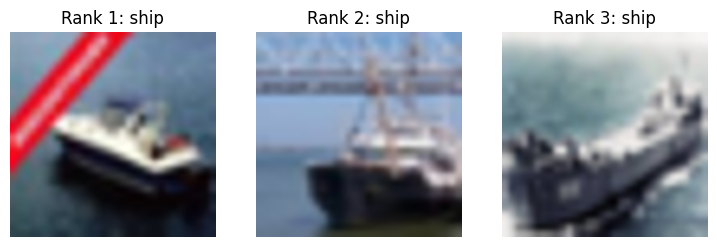


Query: a photo of a horse
  Top-1: image idx=9942 class=horse
  Top-2: image idx=8457 class=bird
  Top-3: image idx=2559 class=horse


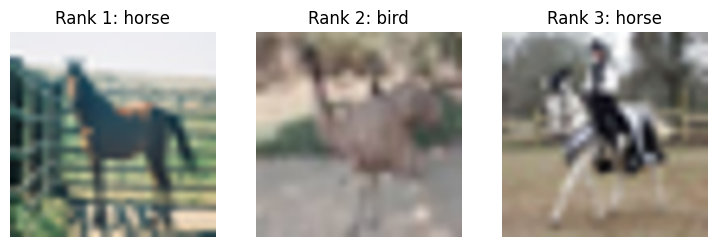


=== Image-to-Text Retrieval ===


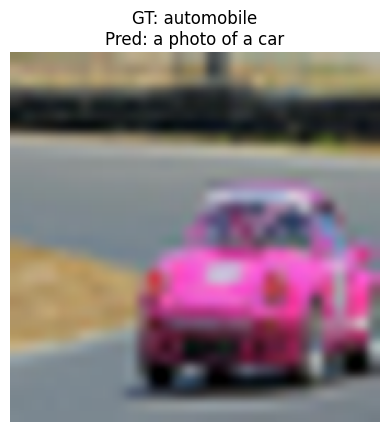

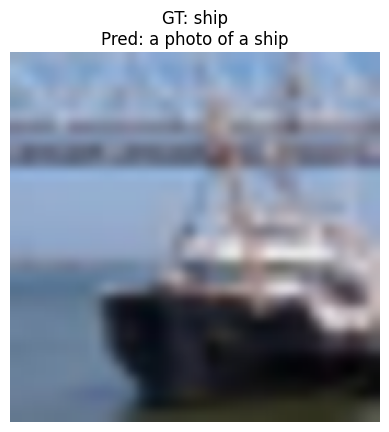

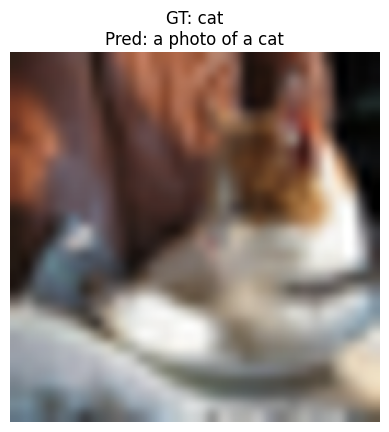

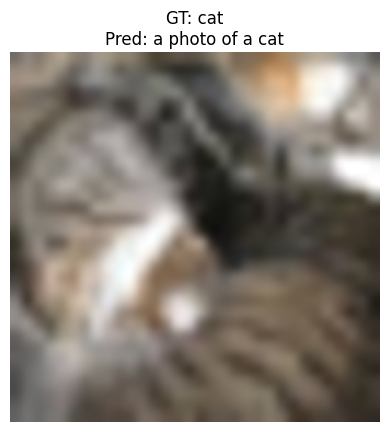

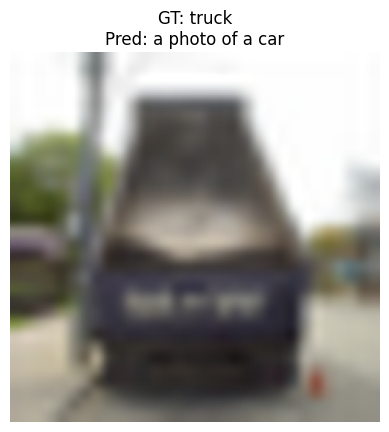

In [ ]:
import random

# 1. Select 20 random CIFAR-10 test images
num_samples = 20
indices = random.sample(range(len(testset)), num_samples)
subset_images = [testset[i][0] for i in indices]  # PIL transformed tensors
subset_labels = [testset[i][1] for i in indices]
subset_classnames = [classnames[l] for l in subset_labels]

print("Sampled classes:", subset_classnames)

# Convert tensors back to PIL for nice plotting
to_pil = transforms.ToPILImage()
subset_pils = [to_pil(img) for img in subset_images]

# 2. Compute image embeddings
clip_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=device).view(1,3,1,1)
clip_std = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=device).view(1,3,1,1)

def get_image_embeddings(img_list):
    imgs = torch.stack(img_list).to(device)  # (N,3,224,224)
    imgs = (imgs - clip_mean) / clip_std
    with torch.no_grad():
        emb = clip_model.encode_image(imgs)
        emb /= emb.norm(dim=-1, keepdim=True)
    return emb

image_embeds = get_image_embeddings(subset_images)

# 3. Define a few text queries
queries = [
    "a photo of a cat",
    "a photo of a dog",
    "a photo of a car",
    "a photo of an airplane",
    "a photo of a ship",
    "a photo of a horse"
]

with torch.no_grad():
    tokenized = clip.tokenize(queries).to(device)
    text_embeds = clip_model.encode_text(tokenized)
    text_embeds /= text_embeds.norm(dim=-1, keepdim=True)

# 4. Text-to-Image Retrieval
sims = text_embeds @ image_embeds.T  # (num_queries, num_images)
topk = 3  # retrieve top-3 matches

print("\n=== Text-to-Image Retrieval ===")
for qi, query in enumerate(queries):
    sim_row = sims[qi].cpu().numpy()
    top_indices = sim_row.argsort()[-topk:][::-1]  # best matches
    print(f"\nQuery: {query}")
    for rank, idx in enumerate(top_indices, 1):
        print(f"  Top-{rank}: image idx={indices[idx]} class={subset_classnames[idx]}")

    # Show retrieved images
    fig, axs = plt.subplots(1, topk, figsize=(3*topk, 3))
    for r, idx in enumerate(top_indices):
        axs[r].imshow(subset_pils[idx])
        axs[r].set_title(f"Rank {r+1}: {subset_classnames[idx]}")
        axs[r].axis("off")
    plt.show()

# 5. Image-to-Text Retrieval
sims_rev = image_embeds @ text_embeds.T  # (num_images, num_queries)
print("\n=== Image-to-Text Retrieval ===")
for i in range(5):  # show first 5 images
    sim_row = sims_rev[i].cpu().numpy()
    best_idx = sim_row.argmax()
    plt.imshow(subset_pils[i])
    plt.axis("off")
    plt.title(f"GT: {subset_classnames[i]}\nPred: {queries[best_idx]}")
    plt.show()


Running t-SNE for CLIP...


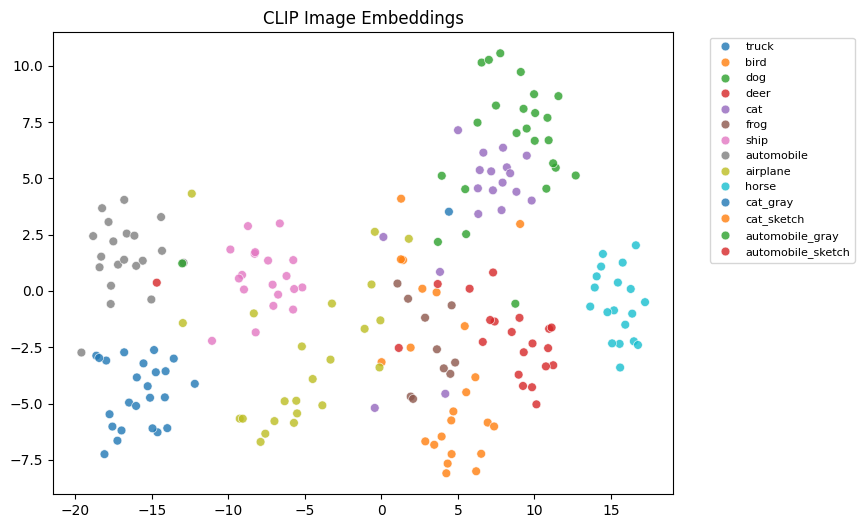

Running t-SNE for ResNet-50...


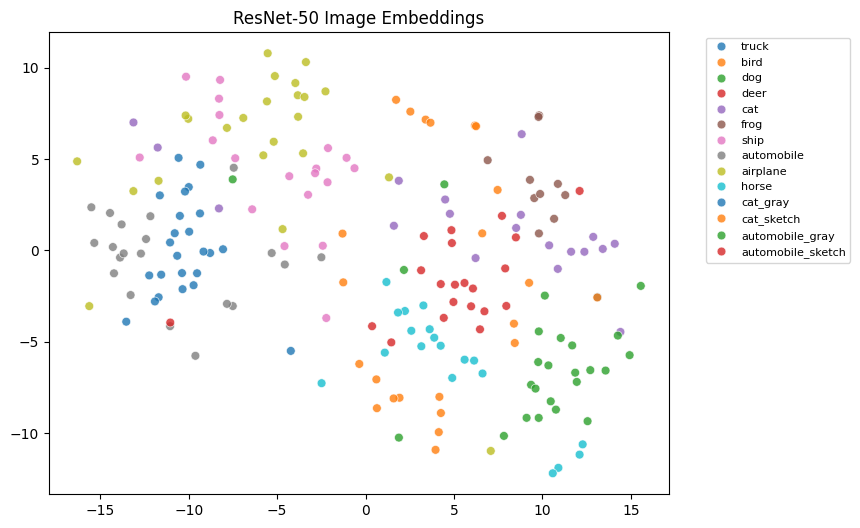

In [ ]:
# ===================================================
# Task 4: Representation Analysis (CLIP vs ResNet-50)
# ===================================================

import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import random

# --- Step 1: Prepare a mixed set of images (CIFAR + OOD variants) ---

num_cifar = 200  # sample subset for speed
indices = random.sample(range(len(testset)), num_cifar)
cifar_imgs = [testset[i][0] for i in indices]
cifar_labels = [classnames[testset[i][1]] for i in indices]

ood_imgs, ood_labels = [], []
for cname in ["cat", "automobile"]:  # fixed: CIFAR10 uses 'automobile'
    idx = classnames.index(cname)
    img, _ = testset[random.choice([i for i, l in enumerate(testset.targets) if l == idx])]
    ood_imgs.append(transforms.Grayscale(num_output_channels=3)(img))
    ood_labels.append(cname + "_gray")
    ood_imgs.append(transforms.RandomAdjustSharpness(5)(img))
    ood_labels.append(cname + "_sketch")

all_imgs = cifar_imgs + ood_imgs
all_labels = cifar_labels + ood_labels

# --- Step 2: CLIP embeddings ---
clip_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=device).view(1, 3, 1, 1)
clip_std = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=device).view(1, 3, 1, 1)

def get_clip_embeds(img_list):
    imgs = torch.stack(img_list).to(device)
    imgs = (imgs - clip_mean) / clip_std
    with torch.no_grad():
        emb = clip_model.encode_image(imgs)
        emb /= emb.norm(dim=-1, keepdim=True)
    return emb.cpu().numpy()

clip_features = get_clip_embeds(all_imgs)

# --- Step 3: ResNet-50 embeddings (your model) ---
def get_resnet50_embeds(img_list, model):
    model.eval()
    feats = []

    def hook_fn(module, inp, out):
        feats.append(out.clone().detach())

    # Register hook on global avgpool (before fc)
    handle = model.avgpool.register_forward_hook(hook_fn)

    imgs = torch.stack(img_list).to(device)
    with torch.no_grad():
        _ = model(imgs)  # forward pass

    handle.remove()
    return feats[0].view(len(imgs), -1).cpu().numpy()

resnet50_features = get_resnet50_embeds(all_imgs, model)

# --- Step 4: Run t-SNE and plot ---
def plot_tsne(features, labels, title):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced = tsne.fit_transform(features)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=reduced[:, 0], y=reduced[:, 1],
        hue=labels, palette="tab10", s=40, alpha=0.8
    )
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
    plt.show()

print("Running t-SNE for CLIP...")
plot_tsne(clip_features, all_labels, "CLIP Image Embeddings")

print("Running t-SNE for ResNet-50...")
plot_tsne(resnet50_features, all_labels, "ResNet-50 Image Embeddings")


NOT COMPLETED

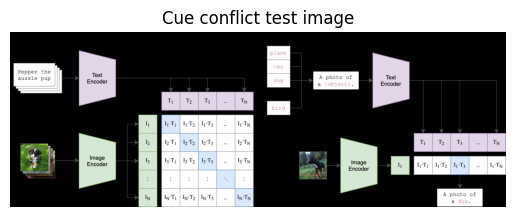

Similarity with 'a photo of a cat': 0.2010
Similarity with 'a photo of an elephant': 0.2008
CLIP prediction: a photo of a cat


In [ ]:
import requests
from PIL import Image
import torch

# Example: load a "cue conflict" style-transfer image
# Here we’ll just fetch a stylized image from the internet for demo.
url = "https://raw.githubusercontent.com/openai/CLIP/main/CLIP.png"  # placeholder, replace with real
img = Image.open(requests.get(url, stream=True).raw).convert("RGB")

plt.imshow(img)
plt.axis("off")
plt.title("Cue conflict test image")
plt.show()

# Preprocess for CLIP
preprocess = clip.load("ViT-B/32", device=device)[1]
image_input = preprocess(img).unsqueeze(0).to(device)

# Define candidate text prompts
texts = ["a photo of a cat", "a photo of an elephant"]
text_tokens = clip.tokenize(texts).to(device)

# Compute embeddings
with torch.no_grad():
    image_features = clip_model.encode_image(image_input)
    text_features = clip_model.encode_text(text_tokens)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    sims = (image_features @ text_features.T).squeeze().cpu().numpy()

for t, s in zip(texts, sims):
    print(f"Similarity with '{t}': {s:.4f}")

print("CLIP prediction:", texts[np.argmax(sims)])


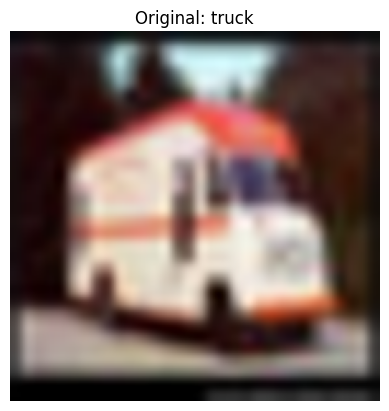

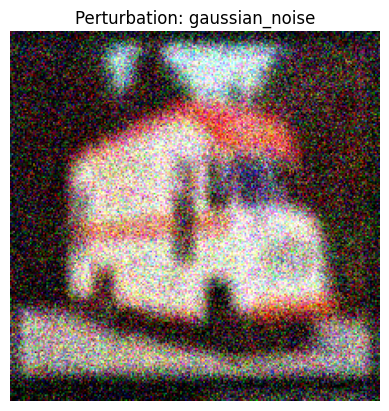

CLIP prediction on gaussian_noise: a photo of a cat


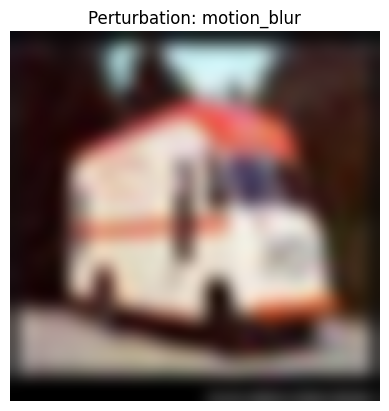

CLIP prediction on motion_blur: a photo of a automobile


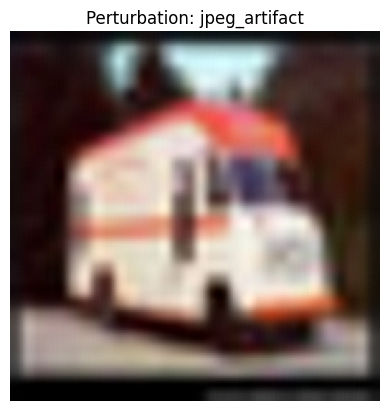

CLIP prediction on jpeg_artifact: a photo of a truck


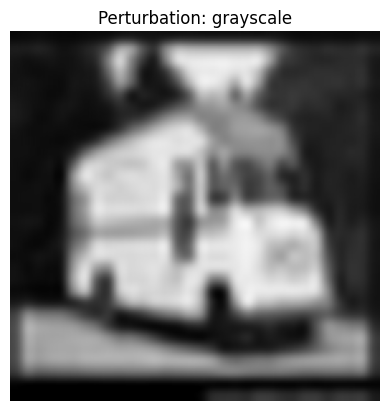

CLIP prediction on grayscale: a photo of a automobile


TypeError: Only torch.uint8 image tensors are supported, but found torch.float32

In [ ]:
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import random
import matplotlib.pyplot as plt # Import matplotlib
from torchvision.transforms import ToPILImage # Import ToPILImage

# Pick a random CIFAR-10 image
idx = random.randint(0, len(testset)-1)
img, label = testset[idx]
plt.imshow(img.permute(1, 2, 0)) # Transpose for plotting
plt.title(f"Original: {classnames[label]}")
plt.axis("off")
plt.show()

# --- Define perturbations ---
perturbations = {
    "gaussian_noise": lambda x: x + torch.randn_like(x) * 0.2,
    "motion_blur": T.GaussianBlur(kernel_size=11, sigma=5.0),
    "jpeg_artifact": T.RandomAdjustSharpness(5),
    "grayscale": T.Grayscale(num_output_channels=3),
    "posterize": T.RandomPosterize(bits=3),
}

# --- Preprocess for CLIP ---
preprocess = clip.load("ViT-B/32", device=device)[1]
to_pil = ToPILImage() # Instantiate ToPILImage

# Candidate text labels (CIFAR-10 classes)
prompts = [f"a photo of a {c}" for c in classnames]
text_tokens = clip.tokenize(prompts).to(device)

with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Function to classify with CLIP
def classify_with_clip(img_tensor): # Renamed input argument for clarity
    img_pil = to_pil(img_tensor) # Convert tensor to PIL Image
    img_in = preprocess(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(img_in)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        sims = (image_features @ text_features.T).squeeze().cpu().numpy()
    return prompts[int(np.argmax(sims))], sims

# --- Run perturbations ---
for name, transform in perturbations.items():
    # apply corruption
    corrupted = transform(img) if callable(transform) else transform(img)
    plt.imshow(corrupted.permute(1, 2, 0)) # Transpose for plotting
    plt.title(f"Perturbation: {name}")
    plt.axis("off")
    plt.show()

    pred, sims = classify_with_clip(corrupted)
    print(f"CLIP prediction on {name}: {pred}")